In [1]:
# This allows us to show the full screen width

from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [2]:
# Load library

import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.linear_model import GammaRegressor
import statsmodels.api as sm
import statsmodels.stats.api as sms
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.metrics import mean_gamma_deviance
import csv
from bevel.bevel.linear_ordinal_regression import OrderedLogit
import matplotlib.pyplot as plt
from scipy.stats import shapiro

# Odds Model

In [3]:
# Load Odds data

Odds = pd.read_csv("/Users/lorenzoleoni/Desktop/Materiale Personale/Statistical Analysis on Classification and Forecasting Models in Football/data/SerieA_Odds.csv", sep=';', decimal=".")

Odds.head()

,Date,Home_Team,Away_Team,Home_Goals,Away_Goals,Win_Home_Bet,Draw_Bet,Win_Away_Bet
0,21/08/21,Internazionale,Genoa,4,0,1.33,5.25,9.00
1,21/08/21,Hellas Verona,Sassuolo,2,3,2.62,3.30,2.62
2,21/08/21,Torino,Atalanta,1,2,5.50,4.33,1.55
3,21/08/21,Empoli,Lazio,1,3,4.60,4.00,1.70
4,22/08/21,Napoli,Venezia,2,0,1.22,6.50,12.00


In [4]:
# Variable Full Time Result and rename columns

Odds.insert(5,'FTR',np.where(Odds['Home_Goals']>Odds['Away_Goals'],'H',np.where(Odds['Home_Goals']==Odds['Away_Goals'],'D','A')))
Odds.rename(columns={'Win_Home_Bet':'HBet','Draw_Bet':'DBet','Win_Away_Bet':'ABet'}, inplace=True)

In [5]:
# Drop the 28 matchweek (models are based on 27 matchweeks)

Odds.drop(Odds.index[265:275], inplace=True)

In [6]:
# Probabilities from odds

Odds['Hprob_Odds'] = (1/Odds['HBet'])/(1/(Odds['HBet'])+1/(Odds['DBet'])+1/(Odds['ABet']))
Odds['Dprob_Odds'] = (1/Odds['DBet'])/(1/(Odds['HBet'])+1/(Odds['DBet'])+1/(Odds['ABet']))
Odds['Aprob_Odds'] = 1 - Odds['Hprob_Odds'] - Odds['Dprob_Odds']
Odds.head()

,Date,Home_Team,Away_Team,Home_Goals,Away_Goals,FTR,HBet,DBet,ABet,Hprob_Odds,Dprob_Odds,Aprob_Odds
0,21/08/21,Internazionale,Genoa,4,0,H,1.33,5.25,9.00,0.713719,0.180809,0.105472
1,21/08/21,Hellas Verona,Sassuolo,2,3,A,2.62,3.30,2.62,0.357918,0.284165,0.357918
2,21/08/21,Torino,Atalanta,1,2,A,5.50,4.33,1.55,0.171863,0.218301,0.609836
3,21/08/21,Empoli,Lazio,1,3,A,4.60,4.00,1.70,0.205936,0.236826,0.557238
4,22/08/21,Napoli,Venezia,2,0,H,1.22,6.50,12.00,0.775579,0.145570,0.078851


In [7]:
# Prediction from odds

Odds['Odds_pred'] = np.where((Odds['Hprob_Odds']>Odds['Dprob_Odds'])&(Odds['Hprob_Odds']>Odds['Aprob_Odds']),'H',np.where((Odds['Dprob_Odds']>Odds['Hprob_Odds'])&(Odds['Dprob_Odds']>Odds['Aprob_Odds']),'D','A'))
Odds.head()

,Date,Home_Team,Away_Team,Home_Goals,Away_Goals,FTR,HBet,DBet,ABet,Hprob_Odds,Dprob_Odds,Aprob_Odds,Odds_pred
0,21/08/21,Internazionale,Genoa,4,0,H,1.33,5.25,9.00,0.713719,0.180809,0.105472,H
1,21/08/21,Hellas Verona,Sassuolo,2,3,A,2.62,3.30,2.62,0.357918,0.284165,0.357918,H
2,21/08/21,Torino,Atalanta,1,2,A,5.50,4.33,1.55,0.171863,0.218301,0.609836,A
3,21/08/21,Empoli,Lazio,1,3,A,4.60,4.00,1.70,0.205936,0.236826,0.557238,A
4,22/08/21,Napoli,Venezia,2,0,H,1.22,6.50,12.00,0.775579,0.145570,0.078851,H


In [8]:
# Confusion matrix

pd.crosstab(Odds['FTR'], Odds['Odds_pred'],dropna= True)

Odds_pred,A,H
FTR,,
A,57,36
D,31,40
H,22,79


In [9]:
# Precision for Odds model

p_odds = (57+79)/265
p_odds

0.5132075471698113

# Ordered Logit Model with TM Value Costant

In [10]:
# Load dataset with all statistics for each game

SerieA = pd.read_csv("/Users/lorenzoleoni/Desktop/Materiale Personale/Statistical Analysis on Classification and Forecasting Models in Football/data/SerieA_21_22.csv", sep=';', decimal=",", parse_dates=['Match_Date'],encoding = 'unicode_escape')
SerieA.head()

,League,Gender,Country,Season,Match_Date,Matchweek,Home_Team,Home_Formation,Home_Score,Home_xG,...,PKwon_15,PKcon_16,OG_17,Recov,Won_Aerial_Duels,Lost_Aerial_Duels,Won_percent_Aerial_Duels,Cup,Cup_Home,Cup_Away
0,Serie A,M,ITA,2021-2022,2021-08-21,1,Internazionale,3-5-1-1,4,1.5,...,0,0,0,65,10,8,55.6,0,0,0
1,Serie A,M,ITA,2021-2022,2021-08-21,1,Internazionale,3-5-1-1,4,1.5,...,0,0,0,54,8,10,44.4,0,0,0
2,Serie A,M,ITA,2021-2022,2021-08-21,1,Hellas Verona,03/04/03,2,2.1,...,1,0,0,62,12,6,66.7,0,0,0
3,Serie A,M,ITA,2021-2022,2021-08-21,1,Hellas Verona,03/04/03,2,2.1,...,0,1,0,66,6,12,33.3,0,0,0
4,Serie A,M,ITA,2021-2022,2021-08-21,1,Empoli,4-4-2_,1,1.3,...,0,1,0,77,6,8,42.9,0,0,0


In [11]:
# Variable Win

SerieA['Win'] = np.where(SerieA.loc[:,'Home_Score']==SerieA.loc[:,'Away_Score'],'D',np.where(SerieA.loc[:,'Home_Score']>SerieA.loc[:,'Away_Score'],'H','A'))

In [12]:
# Load TM_Value for each team

TM_Value = pd.read_csv("/Users/lorenzoleoni/Desktop/Materiale Personale/Statistical Analysis on Classification and Forecasting Models in Football/data/TM_Value_SerieA21_22.csv", sep=';')
TM_Value.head()

,Team,TM_Value
0,Sampdoria,103300000
1,Cagliari,129500000
2,Lazio,267450000
3,Juventus,566400000
4,Venezia,87830000


In [13]:
# Variable TM_Value_Home_Team

TM_Value.rename(columns={'Team':'Home_Team'}, inplace=True)
SerieA = pd.merge(SerieA,TM_Value,on='Home_Team')
SerieA.rename(columns={'TM_Value':'TM_Value_Home_Team'}, inplace=True)

In [14]:
# Variable TM_Value_Away_Team

TM_Value.rename(columns={'Home_Team':'Away_Team'}, inplace=True)
SerieA = pd.merge(SerieA,TM_Value,on='Away_Team')
SerieA.rename(columns={'TM_Value':'TM_Value_Away_Team'}, inplace=True)

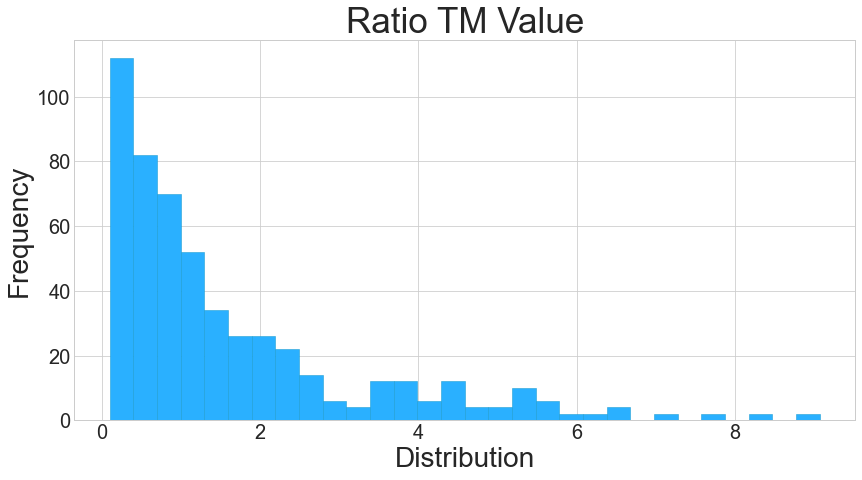

In [15]:
# Distribution ratio TM value

plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid

plt.hist(SerieA['TM_Value_Home_Team']/SerieA['TM_Value_Away_Team'], bins=30, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)

plt.title('Ratio TM Value', fontsize=35) 
plt.xlabel('Distribution', fontsize=28) 
plt.ylabel('Frequency', fontsize=28)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

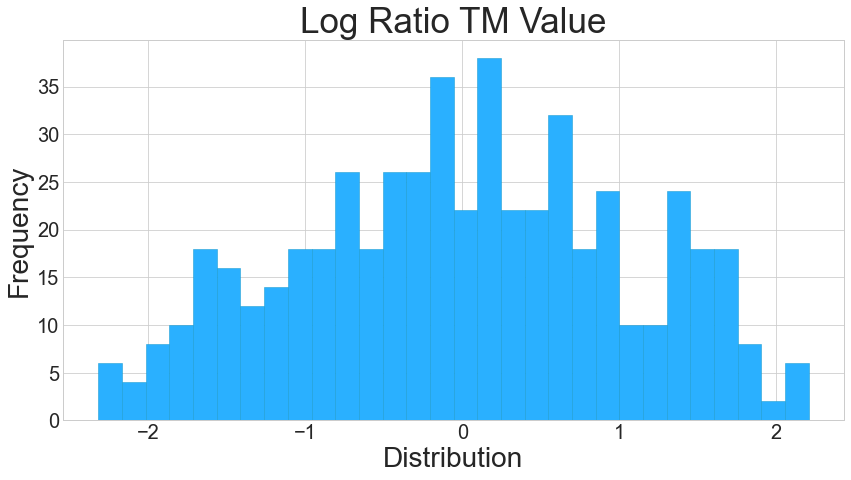

In [16]:
# Distribution log ratio TM value

plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid

plt.hist(np.log(SerieA['TM_Value_Home_Team']/SerieA['TM_Value_Away_Team']), bins=30, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)

plt.title('Log Ratio TM Value', fontsize=35) 
plt.xlabel('Distribution', fontsize=28) 
plt.ylabel('Frequency', fontsize=28)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [17]:
# Variable log_ratio_Value

SerieA['log_ratio_Value'] = np.log(SerieA.loc[:,'TM_Value_Home_Team']/SerieA.loc[:,'TM_Value_Away_Team'])

In [18]:
# Subset Games

Games = SerieA.loc[:,['Matchweek','Match_Date','Home_Team','Away_Team','Home_Score','Away_Score','Win','log_ratio_Value','Cup_Home','Cup_Away']].copy()
Games.head()

,Matchweek,Match_Date,Home_Team,Away_Team,Home_Score,Away_Score,Win,log_ratio_Value,Cup_Home,Cup_Away
0,1,2021-08-21,Internazionale,Genoa,4,0,H,1.627572,0,0
1,1,2021-08-21,Internazionale,Genoa,4,0,H,1.627572,0,0
2,12,2021-11-05,Empoli,Genoa,2,2,D,-0.222682,0,0
3,12,2021-11-05,Empoli,Genoa,2,2,D,-0.222682,0,0
4,9,2021-10-22,Torino,Genoa,3,2,H,0.642340,0,0


In [19]:
# Delete even rows (duplicate games)

Games = Games.sort_index(axis=0)
Games = Games.iloc[::2]
Games = Games.sort_values(by='Matchweek', ascending=True)

In [20]:
# Variable Winvalue

Games['Winvalue'] = np.where(Games.loc[:,'Win']=='H',2,np.where(Games.loc[:,'Win']=='D',1,0))

In [21]:
# Create dfs Team Performances, Goals made and conceded and Pythagorean Expectation (it refers up to previous matches)

Teams = pd.DataFrame(np.zeros((27,20)),columns=Games['Home_Team'].unique())
Goals_for = pd.DataFrame(np.zeros((27,20),dtype=int),columns=Games['Home_Team'].unique())
Goals_against = pd.DataFrame(np.zeros((27,20),dtype=int),columns=Games['Home_Team'].unique())

In [22]:
# Dictionary with column indexs for each team

names = Games['Home_Team'].unique()

mydict = {}

for i,name in enumerate(names):
    mydict[name] = int(i)
    

In [23]:
# Calculate Team Performances (it refers to the last two games),  Goals made,  Goals conceded and Pythagorean Expectation

i = 0
k = 0

for i in range(0,len(Games)):
    
    if (Games['Matchweek'].iloc[i-1] < Games['Matchweek'].iloc[i]) & (i>0): # If it was taken the following matchweek
        k +=1
    
    if k < 26:
    
    ##############################################################################################################################
        
        # IN THIS SECTION ARE CONSIDERED POSTPONED MATCHS. THE PERFORMANCE OF THE TEAMS THAT HAVE NOT PLAYED ARE 
        # EQUAL TO THOSE OF THEIR LAST MATCHES

    ##############################################################################################################################
    
        if k == 19:
            
            Teams.loc[k,'Udinese'] = Teams.loc[k-1,'Udinese']
            Teams.loc[k,'Salernitana'] = Teams.loc[k-1,'Salernitana']
            
            Goals_for.loc[k,'Udinese'] = Goals_for.loc[k-1,'Udinese']
            Goals_for.loc[k,'Salernitana'] = Goals_for.loc[k-1,'Salernitana']
            
            Goals_against.loc[k,'Udinese'] = Goals_against.loc[k-1,'Udinese']
            Goals_against.loc[k,'Salernitana'] = Goals_against.loc[k-1,'Salernitana']
            
        
        if k == 20:
            
            Teams.loc[k,'Fiorentina'] = Teams.loc[k-1,'Fiorentina']
            Teams.loc[k,'Udinese'] = Teams.loc[k-1,'Udinese']
            
            Teams.loc[k,'Bologna'] = Teams.loc[k-1,'Bologna']
            Teams.loc[k,'Internazionale'] = Teams.loc[k-1,'Internazionale']
            
            Teams.loc[k,'Atalanta'] = Teams.loc[k-1,'Atalanta']
            Teams.loc[k,'Torino'] = Teams.loc[k-1,'Torino']
            
            Teams.loc[k,'Salernitana'] = Teams.loc[k-1,'Salernitana']
            Teams.loc[k,'Venezia'] = Teams.loc[k-1,'Venezia']
            
            #
            
            Goals_for.loc[k,'Fiorentina'] = Goals_for.loc[k-1,'Fiorentina']
            Goals_for.loc[k,'Udinese'] = Goals_for.loc[k-1,'Udinese']
        
            Goals_for.loc[k,'Bologna'] = Goals_for.loc[k-1,'Bologna']
            Goals_for.loc[k,'Internazionale'] = Goals_for.loc[k-1,'Internazionale']
            
            Goals_for.loc[k,'Atalanta'] = Goals_for.loc[k-1,'Atalanta']
            Goals_for.loc[k,'Torino'] = Goals_for.loc[k-1,'Torino']
            
            Goals_for.loc[k,'Salernitana'] = Goals_for.loc[k-1,'Salernitana']
            Goals_for.loc[k,'Venezia'] = Goals_for.loc[k-1,'Venezia']
            
            #
            
            Goals_against.loc[k,'Fiorentina'] = Goals_against.loc[k-1,'Fiorentina']
            Goals_against.loc[k,'Udinese'] = Goals_against.loc[k-1,'Udinese']
            
            Goals_against.loc[k,'Bologna'] = Goals_against.loc[k-1,'Bologna']
            Goals_against.loc[k,'Internazionale'] = Goals_against.loc[k-1,'Internazionale']
            
            Goals_against.loc[k,'Atalanta'] = Goals_against.loc[k-1,'Atalanta']
            Goals_against.loc[k,'Torino'] = Goals_against.loc[k-1,'Torino']
            
            Goals_against.loc[k,'Salernitana'] = Goals_against.loc[k-1,'Salernitana']
            Goals_against.loc[k,'Venezia'] = Goals_against.loc[k-1,'Venezia']
            
  
    ##############################################################################################################################
    ##############################################################################################################################
        
        Goals_for.iloc[k+1,mydict[Games['Home_Team'].iloc[i]]] = Goals_for.iloc[k,mydict[Games['Home_Team'].iloc[i]]] + \
        Games['Home_Score'].iloc[i]
        
        Goals_for.iloc[k+1,mydict[Games['Away_Team'].iloc[i]]] = Goals_for.iloc[k,mydict[Games['Away_Team'].iloc[i]]] + \
        Games['Away_Score'].iloc[i]
        
        Goals_against.iloc[k+1,mydict[Games['Home_Team'].iloc[i]]] = Goals_against.iloc[k,mydict[Games['Home_Team'].iloc[i]]] + \
        Games['Away_Score'].iloc[i]
        
        Goals_against.iloc[k+1,mydict[Games['Away_Team'].iloc[i]]] = Goals_against.iloc[k,mydict[Games['Away_Team'].iloc[i]]] + \
        Games['Home_Score'].iloc[i]
        
        
        # Home Win
    
        if (Games['Winvalue'].iloc[i] == 2)&(Teams.iloc[k,mydict[Games['Home_Team'].iloc[i]]] <= 1):
            Teams.iloc[k+1,mydict[Games['Home_Team'].iloc[i]]] =  Teams.iloc[k,mydict[Games['Home_Team'].iloc[i]]] + 1

            if Teams.iloc[k,mydict[Games['Away_Team'].iloc[i]]] >= - 1:
                Teams.iloc[k+1,mydict[Games['Away_Team'].iloc[i]]] =  Teams.iloc[k,mydict[Games['Away_Team'].iloc[i]]] - 1

            else:
                Teams.iloc[k+1,mydict[Games['Away_Team'].iloc[i]]] =  - 2

        elif (Games['Winvalue'].iloc[i] == 2)&(Teams.iloc[k,mydict[Games['Home_Team'].iloc[i]]] > 1):
            Teams.iloc[k+1,mydict[Games['Home_Team'].iloc[i]]] =  2

            if Teams.iloc[k,mydict[Games['Away_Team'].iloc[i]]] >= - 1:
                Teams.iloc[k+1,mydict[Games['Away_Team'].iloc[i]]] =  Teams.iloc[k,mydict[Games['Away_Team'].iloc[i]]] - 1

            else:
                Teams.iloc[k+1,mydict[Games['Away_Team'].iloc[i]]] =  - 2

        # Draw

        if (Games['Winvalue'].iloc[i] == 1)&(Teams.iloc[k,mydict[Games['Home_Team'].iloc[i]]] >= -1.5):
            Teams.iloc[k+1,mydict[Games['Home_Team'].iloc[i]]] =  Teams.iloc[k,mydict[Games['Home_Team'].iloc[i]]] - 0.5

            if Teams.iloc[k,mydict[Games['Away_Team'].iloc[i]]] >= - 1.5:
                Teams.iloc[k+1,mydict[Games['Away_Team'].iloc[i]]]  =  Teams.iloc[k,mydict[Games['Away_Team'].iloc[i]]] - 0.5

            else:
                Teams.iloc[k+1,mydict[Games['Away_Team'].iloc[i]]] =  - 2

        elif (Games['Winvalue'].iloc[i] == 1)&(Teams.iloc[k,mydict[Games['Home_Team'].iloc[i]]] < -1.5):
            Teams.iloc[k+1,mydict[Games['Home_Team'].iloc[i]]] =  - 2

            if Teams.iloc[k,mydict[Games['Away_Team'].iloc[i]]] >= - 1.5:
                Teams.iloc[k+1,mydict[Games['Away_Team'].iloc[i]]] =  Teams.iloc[k,mydict[Games['Away_Team'].iloc[i]]] - 0.5

            else:
                Teams.iloc[k+1,mydict[Games['Away_Team'].iloc[i]]] =  - 2

        # Away Win

        if (Games['Winvalue'].iloc[i] == 0)&(Teams.iloc[k,mydict[Games['Home_Team'].iloc[i]]] >= -1):
            Teams.iloc[k+1,mydict[Games['Home_Team'].iloc[i]]] =  Teams.iloc[k,mydict[Games['Home_Team'].iloc[i]]] - 1

            if Teams.iloc[k,mydict[Games['Away_Team'].iloc[i]]] <= 1:
                Teams.iloc[k+1,mydict[Games['Away_Team'].iloc[i]]] =  Teams.iloc[k,mydict[Games['Away_Team'].iloc[i]]] + 1

            else:
                Teams.iloc[k+1,mydict[Games['Away_Team'].iloc[i]]] = 2

        elif (Games['Winvalue'].iloc[i] == 0)&(Teams.iloc[k,mydict[Games['Home_Team'].iloc[i]]] < -1):
            Teams.iloc[k+1,mydict[Games['Home_Team'].iloc[i]]] =  - 2

            if Teams.iloc[k,mydict[Games['Away_Team'].iloc[i]]] <= 1:
                Teams.iloc[k+1,mydict[Games['Away_Team'].iloc[i]]] =  Teams.iloc[k,mydict[Games['Away_Team'].iloc[i]]] + 1

            else:
                Teams.iloc[k+1,mydict[Games['Away_Team'].iloc[i]]] = 2
            
    i +=1
    
Teams.head(20)

,Internazionale,Cagliari,Empoli,Napoli,Udinese,Hellas Verona,Sampdoria,Torino,Roma,Bologna,Genoa,Atalanta,Lazio,Milan,Fiorentina,Juventus,Salernitana,Sassuolo,Spezia,Venezia
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,-0.5,-1.0,1.0,-0.5,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-0.5,-1.0,1.0,-0.5,-1.0
2,2.0,-1.5,0.0,2.0,0.5,-2.0,-1.5,-2.0,2.0,0.5,-2.0,0.5,2.0,2.0,0.0,-1.5,-2.0,0.5,-1.5,-2.0
3,1.5,-2.0,-1.0,2.0,1.5,-2.0,-2.0,-1.0,2.0,1.5,-1.0,-0.5,1.0,2.0,1.0,-2.0,-2.0,-0.5,-2.0,-1.0
4,2.0,-2.0,-2.0,2.0,0.5,-1.0,-1.0,0.0,1.0,0.5,-2.0,0.5,0.5,1.5,2.0,-2.0,-2.0,-1.5,-1.0,-2.0
5,2.0,-2.0,-1.0,2.0,-0.5,-1.5,-2.0,-0.5,2.0,0.0,-2.0,1.5,0.0,2.0,1.0,-1.0,-2.0,-2.0,-2.0,-2.0
6,1.5,-2.0,0.0,2.0,-1.5,-2.0,-2.0,-1.0,1.0,-1.0,-2.0,1.0,1.0,2.0,2.0,0.0,-2.0,-1.0,-2.0,-2.0
7,2.0,-2.0,-1.0,2.0,-2.0,-1.0,-2.0,-2.0,2.0,0.0,-2.0,0.0,0.0,2.0,1.0,1.0,-1.0,-2.0,-2.0,-2.0
8,1.0,-1.0,-2.0,2.0,-2.0,-2.0,-2.0,-2.0,1.0,-0.5,-2.0,1.0,1.0,2.0,0.0,2.0,-2.0,-2.0,-1.0,-1.0
9,0.5,-2.0,-1.0,1.5,-2.0,-1.0,-1.0,-1.0,0.5,-1.5,-2.0,0.5,0.0,2.0,1.0,1.5,-2.0,-1.0,-2.0,-2.0


In [24]:
# Subset Games

Games = Games[['Matchweek','Match_Date','Home_Team','Away_Team','Win','log_ratio_Value','Cup_Home','Cup_Away','Winvalue']].reset_index(drop = True)

In [25]:
# Add variables Performance and Pythagorean expectation for home and away teams created before

i = 0
k = 0

Games['Home_Performance'] = [0]*len(Games)
Games['Away_Performance'] = [0]*len(Games)
Games['Home_Diff_Goals'] = [0]*len(Games)
Games['Away_Diff_Goals'] = [0]*len(Games)

for i in range(0,len(Games)):
    
    if (Games['Matchweek'].iloc[i-1] < Games['Matchweek'].iloc[i]) & (i>0):
        k +=1
    
    if k<= 26:
        
        Games.loc[i,'Home_Performance'] = Teams.iloc[k,mydict[Games['Home_Team'].iloc[i]]]
        Games.loc[i,'Away_Performance'] = Teams.iloc[k,mydict[Games['Away_Team'].iloc[i]]]
        
        Games.loc[i,'Home_Diff_Goals'] = Goals_for.iloc[k,mydict[Games['Home_Team'].iloc[i]]] - Goals_against.iloc[k,mydict[Games['Home_Team'].iloc[i]]]
        Games.loc[i,'Away_Diff_Goals'] = Goals_for.iloc[k,mydict[Games['Away_Team'].iloc[i]]] - Goals_against.iloc[k,mydict[Games['Away_Team'].iloc[i]]]
        
    i += 1
    
#Games

In [26]:
# Save pandas for statistical inference in R

Games.to_csv("/Users/lorenzoleoni/Desktop/Materiale Personale/Statistical Analysis on Classification and Forecasting Models in Football/data/OLM.csv",index=False)

## MAIN + DIFF

In [27]:
# ORDERED LOGIT MODEL WITH TM VALUES COSTANT MAIN + DIFF

TMValue_Costant = OrderedLogit()

Regressors = Games[['log_ratio_Value','Home_Performance','Away_Performance', 'Home_Diff_Goals','Away_Diff_Goals']]

TMValue_Costant.fit(Regressors, Games['Winvalue'])

TMValue_Costant.print_summary()

n=265
                    beta  se(beta)      p  lower 0.95  upper 0.95     
attribute names                                                       
log_ratio_Value   1.5088    0.2358 0.0000      1.0466      1.9710  ***
Home_Performance -0.2192    0.1288 0.0887     -0.4715      0.0332    .
Away_Performance  0.2035    0.1225 0.0966     -0.0366      0.4435    .
Home_Diff_Goals  -0.0154    0.0149 0.3011     -0.0447      0.0138     
Away_Diff_Goals   0.0178    0.0155 0.2520     -0.0127      0.0483     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Somers' D = 0.382


In [28]:
# Predicted probabilities Main + Diff

Games['Aprob_TMValue_Costant'] = 1/(1+np.exp(-(TMValue_Costant.coef_[5]\
                                               -TMValue_Costant.coef_[0]*Games['log_ratio_Value']\
                                               -TMValue_Costant.coef_[1]*Games['Home_Performance']\
                                               -TMValue_Costant.coef_[2]*Games['Away_Performance']\
                                               -TMValue_Costant.coef_[3]*Games['Home_Diff_Goals']\
                                               -TMValue_Costant.coef_[4]*Games['Away_Diff_Goals'])))

Games['Dprob_TMValue_Costant'] = 1/(1+np.exp(-(TMValue_Costant.coef_[6]\
                                               -TMValue_Costant.coef_[0]*Games['log_ratio_Value']\
                                               -TMValue_Costant.coef_[1]*Games['Home_Performance']\
                                               -TMValue_Costant.coef_[2]*Games['Away_Performance']\
                                               -TMValue_Costant.coef_[3]*Games['Home_Diff_Goals']\
                                               -TMValue_Costant.coef_[4]*Games['Away_Diff_Goals'])))\
                                               - Games['Aprob_TMValue_Costant']

Games['Hprob_TMValue_Costant'] = 1 - Games['Aprob_TMValue_Costant'] - Games['Dprob_TMValue_Costant']

In [29]:
# Result prediction Main + Diff

Maxprob = Games[['Aprob_TMValue_Costant','Dprob_TMValue_Costant','Hprob_TMValue_Costant']].max(axis=1)

Games['TMValue_Costant_pred']=np.where(Maxprob == Games['Aprob_TMValue_Costant'],'A',\
                               np.where(Maxprob == Games['Dprob_TMValue_Costant'],'D','H'))

In [30]:
# Confusion matrix Main + Diff

pd.crosstab(Games['Win'], Games['TMValue_Costant_pred'],dropna= True)

TMValue_Costant_pred,A,H
Win,,
A,62,31
D,36,35
H,24,77


In [31]:
# Precision for model TMValue_costant Main + Diff

p_TMValue_Costant = (62+77)/265

p_TMValue_Costant

0.5245283018867924

## MAIN + CUP

In [32]:
# ORDERED LOGIT MODEL WITH TM VALUES COSTANT MAIN + CUP

TMValue_Costant = OrderedLogit()

Regressors = Games[['log_ratio_Value','Home_Performance','Away_Performance', 'Cup_Home','Cup_Away']]

TMValue_Costant.fit(Regressors, Games['Winvalue'])

TMValue_Costant.print_summary()

n=265
                    beta  se(beta)      p  lower 0.95  upper 0.95     
attribute names                                                       
log_ratio_Value   1.3561    0.2004 0.0000      0.9633      1.7488  ***
Home_Performance -0.2402    0.1065 0.0242     -0.4490     -0.0314    *
Away_Performance  0.2528    0.1132 0.0256      0.0308      0.4747    *
Cup_Home         -0.2092    0.3657 0.5673     -0.9260      0.5076     
Cup_Away          0.0292    0.3653 0.9363     -0.6868      0.7452     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Somers' D = 0.383


In [33]:
# Predicted probabilities Main + Cup

Games['Aprob_TMValue_Costant'] = 1/(1+np.exp(-(TMValue_Costant.coef_[5]\
                                               -TMValue_Costant.coef_[0]*Games['log_ratio_Value']\
                                               -TMValue_Costant.coef_[1]*Games['Home_Performance']\
                                               -TMValue_Costant.coef_[2]*Games['Away_Performance'] \
                                               -TMValue_Costant.coef_[3]*Games['Cup_Home']\
                                               -TMValue_Costant.coef_[4]*Games['Cup_Away'])))

Games['Dprob_TMValue_Costant'] = 1/(1+np.exp(-(TMValue_Costant.coef_[6]\
                                               -TMValue_Costant.coef_[0]*Games['log_ratio_Value']\
                                               -TMValue_Costant.coef_[1]*Games['Home_Performance']\
                                               -TMValue_Costant.coef_[2]*Games['Away_Performance']\
                                               -TMValue_Costant.coef_[3]*Games['Cup_Home']\
                                               -TMValue_Costant.coef_[4]*Games['Cup_Away'])))\
                                               - Games['Aprob_TMValue_Costant']

Games['Hprob_TMValue_Costant'] = 1 - Games['Aprob_TMValue_Costant'] - Games['Dprob_TMValue_Costant']

In [34]:
# Result prediction Main + Cup

Maxprob = Games[['Aprob_TMValue_Costant','Dprob_TMValue_Costant','Hprob_TMValue_Costant']].max(axis=1)

Games['TMValue_Costant_pred']=np.where(Maxprob == Games['Aprob_TMValue_Costant'],'A',\
                               np.where(Maxprob == Games['Dprob_TMValue_Costant'],'D','H'))

In [35]:
# Confusion matrix Main + Cup

pd.crosstab(Games['Win'], Games['TMValue_Costant_pred'],dropna= True)

TMValue_Costant_pred,A,H
Win,,
A,65,28
D,35,36
H,23,78


In [36]:
# Precision for model TMValue_costant Main + Cup

p_TMValue_Costant = (65+78)/265

p_TMValue_Costant

0.539622641509434

## MAIN (Best)

In [37]:
# ORDERED LOGIT MODEL WITH TM VALUES COSTANT MAIN

TMValue_Costant = OrderedLogit()

Regressors = Games[['log_ratio_Value','Home_Performance','Away_Performance']]

TMValue_Costant.fit(Regressors, Games['Winvalue'])

TMValue_Costant.print_summary()

n=265
                    beta  se(beta)      p  lower 0.95  upper 0.95     
attribute names                                                       
log_ratio_Value   1.3323    0.1936 0.0000      0.9528      1.7118  ***
Home_Performance -0.2447    0.1063 0.0213     -0.4531     -0.0363    *
Away_Performance  0.2457    0.1088 0.0240      0.0324      0.4590    *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Somers' D = 0.383


In [38]:
# Predicted probabilities Main

Games['Aprob_TMValue_Costant'] = 1/(1+np.exp(-(TMValue_Costant.coef_[3]\
                                               -TMValue_Costant.coef_[0]*Games['log_ratio_Value']
                                               -TMValue_Costant.coef_[1]*Games['Home_Performance']\
                                               -TMValue_Costant.coef_[2]*Games['Away_Performance'])))

Games['Dprob_TMValue_Costant'] = 1/(1+np.exp(-(TMValue_Costant.coef_[4]\
                                               -TMValue_Costant.coef_[0]*Games['log_ratio_Value']\
                                               -TMValue_Costant.coef_[1]*Games['Home_Performance']\
                                               -TMValue_Costant.coef_[2]*Games['Away_Performance'])))\
                                               -Games['Aprob_TMValue_Costant']

Games['Hprob_TMValue_Costant'] = 1 - Games['Aprob_TMValue_Costant'] - Games['Dprob_TMValue_Costant']

In [39]:
# Result prediction Main

Maxprob = Games[['Aprob_TMValue_Costant','Dprob_TMValue_Costant','Hprob_TMValue_Costant']].max(axis=1)

Games['TMValue_Costant_pred']=np.where(Maxprob == Games['Aprob_TMValue_Costant'],'A',\
                               np.where(Maxprob == Games['Dprob_TMValue_Costant'],'D','H'))

In [40]:
# Confusion matrix Main

pd.crosstab(Games['Win'], Games['TMValue_Costant_pred'],dropna= True)

TMValue_Costant_pred,A,H
Win,,
A,66,27
D,33,38
H,23,78


In [41]:
# Precision for model TMValue_costant Main

p_TMValue_Costant = (66+78)/265

p_TMValue_Costant

0.5433962264150943

# Ordered Logit Model with TM Value for each Lineups

In [42]:
# Lineups and TM Value

ln_TM = pd.read_csv("/Users/lorenzoleoni/Desktop/Materiale Personale/Statistical Analysis on Classification and Forecasting Models in Football/data/ln_TM.csv", sep=',', parse_dates=['Matchday'])

ln_TM.sort_values(by=['Matchday','Team'], ascending=[True,True], inplace=True)

ln_TM.reset_index(drop=True, inplace=True)

ln_TM

,Matchday,Team,Player_Name,Starting,Min,TMValue
0,2021-08-21,Atalanta,Aleksei Miranchuk,Bench,34,11000000.0
1,2021-08-21,Atalanta,Berat Djimsiti,Pitch,90,22000000.0
2,2021-08-21,Atalanta,Giuseppe Pezzella,Bench,15,6000000.0
3,2021-08-21,Atalanta,Joakim Mæhle,Pitch,90,17000000.0
4,2021-08-21,Atalanta,José Luis Palomino,Pitch,90,9000000.0
...,...,...,...,...,...,...
7956,2022-03-06,Venezia,Ridgeciano Haps,Pitch,90,3000000.0
7957,2022-03-06,Venezia,Sergio Romero,Pitch,90,1000000.0
7958,2022-03-06,Venezia,Sofian Kiyine,Pitch,63,2300000.0
7959,2022-03-06,Venezia,Tanner Tessmann,Bench,16,2500000.0


In [43]:
# Drop matchweek 28 (the analysis is based on 27 matchweek)

i = 0

for i in range(0,len(ln_TM)):
    
    if ln_TM.loc[i,'Matchday'] > pd.to_datetime('2022-02-28'):
        
        ln_TM.drop(i,axis=0,inplace=True)

In [44]:
# Create columns for TM value of lineups for each match

Games['ln_TM_Home'] = [0]*len(Games)

Games['ln_TM_Away'] = [0]*len(Games)

In [45]:
# Real contribution of a player in the lineup value of the team in each match

ln_TM['TMValue_Contribution'] = (ln_TM['TMValue']*ln_TM['Min'])/90

In [46]:
Tot_TMValue_Lineups = ln_TM.groupby(['Matchday','Team'])['TMValue_Contribution'].sum().reset_index()

Tot_TMValue_Lineups.head()

,Matchday,Team,TMValue_Contribution
0,2021-08-21,Atalanta,2.193333e+08
1,2021-08-21,Empoli,4.540000e+07
2,2021-08-21,Genoa,3.276111e+07
3,2021-08-21,Hellas Verona,5.661778e+07
4,2021-08-21,Internazionale,3.276444e+08


In [47]:
# Sum of the value of each player in the lineups in each match

i = 0

for i in range(0,len(Games)):
    
    for k in range(0,len(Tot_TMValue_Lineups)):
        
        if (Tot_TMValue_Lineups.loc[k,'Matchday'] == Games.loc[i,'Match_Date'])&(Tot_TMValue_Lineups.loc[k,'Team'] == Games.loc[i,'Home_Team']):
            
            Games.loc[i,'ln_TM_Home'] = Tot_TMValue_Lineups.loc[k,'TMValue_Contribution']
            
        if (Tot_TMValue_Lineups.loc[k,'Matchday'] == Games.loc[i,'Match_Date'])&(Tot_TMValue_Lineups.loc[k,'Team'] == Games.loc[i,'Away_Team']):
            
            Games.loc[i,'ln_TM_Away'] = Tot_TMValue_Lineups.loc[k,'TMValue_Contribution']
            
Games.head()

,Matchweek,Match_Date,Home_Team,Away_Team,Win,log_ratio_Value,Cup_Home,Cup_Away,Winvalue,Home_Performance,Away_Performance,Home_Diff_Goals,Away_Diff_Goals,Aprob_TMValue_Costant,Dprob_TMValue_Costant,Hprob_TMValue_Costant,TMValue_Costant_pred,ln_TM_Home,ln_TM_Away
0,1,2021-08-21,Internazionale,Genoa,H,1.627572,0,0,2,0.0,0.0,0,0,0.050366,0.122494,0.827140,H,3.276444e+08,3.276111e+07
1,1,2021-08-23,Cagliari,Spezia,D,0.615186,0,0,1,0.0,0.0,0,0,0.169670,0.276364,0.553966,H,8.706111e+07,3.377556e+07
2,1,2021-08-21,Empoli,Lazio,A,-1.127633,0,0,0,0.0,0.0,0,0,0.675672,0.215737,0.108591,A,4.540000e+07,1.649189e+08
3,1,2021-08-22,Napoli,Venezia,H,1.750837,0,0,2,0.0,0.0,0,0,0.043067,0.107557,0.849376,H,2.583000e+08,1.436000e+07
4,1,2021-08-22,Udinese,Juventus,D,-1.702147,0,0,1,0.0,0.0,0,0,0.817480,0.128895,0.053625,A,5.551889e+07,2.200167e+08


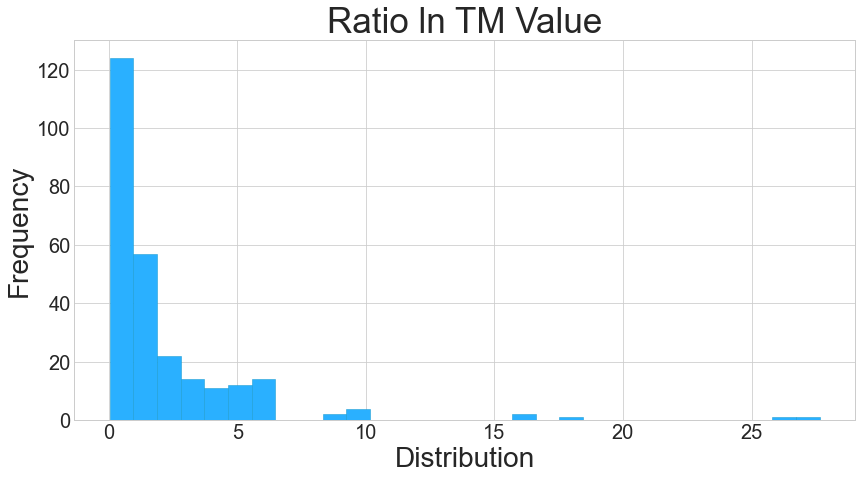

In [48]:
# Distribution ratio ln TM value

plt.figure(figsize=(14,7)) # Make it 14x7 inch

plt.style.use('seaborn-whitegrid') # nice and clean grid

plt.hist(Games['ln_TM_Home']/Games['ln_TM_Away'], bins=30, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)

plt.title('Ratio ln TM Value', fontsize=35)

plt.xlabel('Distribution', fontsize=28) 

plt.ylabel('Frequency', fontsize=28)

plt.xticks(fontsize=20)

plt.yticks(fontsize=20)

plt.show()

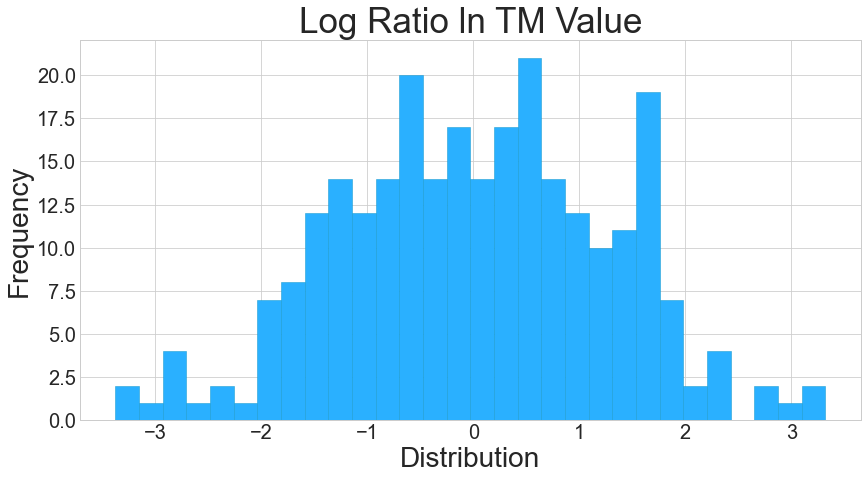

In [49]:
# Distribution log ratio ln TM value

plt.figure(figsize=(14,7)) # Make it 14x7 inch

plt.style.use('seaborn-whitegrid') # nice and clean grid

plt.hist(np.log(Games['ln_TM_Home']/Games['ln_TM_Away']), bins=30, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)

plt.title('Log Ratio ln TM Value', fontsize=35) 

plt.xlabel('Distribution', fontsize=28) 

plt.ylabel('Frequency', fontsize=28)

plt.xticks(fontsize=20)

plt.yticks(fontsize=20)

plt.show()

In [50]:
# Variable log_ratio_ln_TM

Games['log_ratio_ln_TM'] = np.log(Games.loc[:,'ln_TM_Home']/Games.loc[:,'ln_TM_Away'])

In [51]:
# Save pandas for statistical inference in R

Games.to_csv("/Users/lorenzoleoni/Desktop/Materiale Personale/Statistical Analysis on Classification and Forecasting Models in Football/data/OLM_ln.csv",index=False)

## MAIN + CUP

In [52]:
# ORDERED LOGIT MODEL WITH TM VALUE FOR EACH LINEUPS MAIN + CUP

TMValue_Lineups = OrderedLogit()

Regressors = Games[['log_ratio_ln_TM','Home_Performance','Away_Performance','Cup_Home','Cup_Away']]

TMValue_Lineups.fit(Regressors, Games['Winvalue'])

TMValue_Lineups.print_summary()

n=265
                    beta  se(beta)      p  lower 0.95  upper 0.95     
attribute names                                                       
log_ratio_ln_TM   1.2308    0.1701 0.0000      0.8973      1.5643  ***
Home_Performance -0.2823    0.1070 0.0083     -0.4920     -0.0727   **
Away_Performance  0.2826    0.1135 0.0128      0.0601      0.5051    *
Cup_Home         -0.1470    0.3633 0.6857     -0.8590      0.5650     
Cup_Away         -0.0294    0.3691 0.9364     -0.7528      0.6939     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Somers' D = 0.408


In [53]:
# Predicted probabilities Main + Cup

Games['Aprob_TMValue_Lineups'] = 1/(1+np.exp(-(TMValue_Lineups.coef_[5]\
                               -TMValue_Lineups.coef_[0]*Games['log_ratio_ln_TM']\
                               -TMValue_Lineups.coef_[1]*Games['Home_Performance']\
                               -TMValue_Lineups.coef_[2]*Games['Away_Performance']\
                               -TMValue_Lineups.coef_[3]*Games['Cup_Home']\
                               -TMValue_Lineups.coef_[4]*Games['Cup_Away'])))

Games['Dprob_TMValue_Lineups'] = 1/(1+np.exp(-(TMValue_Lineups.coef_[6]\
                               -TMValue_Lineups.coef_[0]*Games['log_ratio_ln_TM']\
                               -TMValue_Lineups.coef_[1]*Games['Home_Performance']\
                               -TMValue_Lineups.coef_[2]*Games['Away_Performance']\
                               -TMValue_Lineups.coef_[3]*Games['Cup_Home']\
                               -TMValue_Lineups.coef_[4]*Games['Cup_Away'])))\
                               -Games['Aprob_TMValue_Lineups']

Games['Hprob_TMValue_Lineups'] = 1 - Games['Aprob_TMValue_Lineups'] - Games['Dprob_TMValue_Lineups']

In [54]:
# Result prediction Main + Cup

Maxprob = Games[['Aprob_TMValue_Lineups','Dprob_TMValue_Lineups','Hprob_TMValue_Lineups']].max(axis=1)

Games['TMValue_Lineups_pred']=np.where(Maxprob == Games['Aprob_TMValue_Lineups'],'A',\
                               np.where(Maxprob == Games['Dprob_TMValue_Lineups'],'D','H'))

In [55]:
# Confusion matrix Main + Cup

pd.crosstab(Games['Win'], Games['TMValue_Lineups_pred'],dropna= True)

TMValue_Lineups_pred,A,D,H
Win,,,
A,63,4,26
D,30,2,39
H,20,3,78


In [56]:
# Precision for model TMValue_lineups Main + Cup

p_TMValue_Lineups = (63+78+2)/265

p_TMValue_Lineups

0.539622641509434

## MAIN

In [57]:
# ORDERED LOGIT MODEL WITH TM VALUE FOR EACH LINEUPS MAIN

TMValue_Lineups = OrderedLogit()

Regressors = Games[['log_ratio_ln_TM','Home_Performance','Away_Performance']]

TMValue_Lineups.fit(Regressors, Games['Winvalue'])

TMValue_Lineups.print_summary()

n=265
                    beta  se(beta)      p  lower 0.95  upper 0.95     
attribute names                                                       
log_ratio_ln_TM   1.2203    0.1663 0.0000      0.8943      1.5463  ***
Home_Performance -0.2860    0.1063 0.0071     -0.4943     -0.0776   **
Away_Performance  0.2736    0.1079 0.0112      0.0621      0.4852    *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Somers' D = 0.406


In [58]:
# Predicted probabilities Main

Games['Aprob_TMValue_Lineups'] = 1/(1+np.exp(-(TMValue_Lineups.coef_[3]\
                               -TMValue_Lineups.coef_[0]*Games['log_ratio_ln_TM']\
                               -TMValue_Lineups.coef_[1]*Games['Home_Performance']\
                               -TMValue_Lineups.coef_[2]*Games['Away_Performance'])))

Games['Dprob_TMValue_Lineups'] = 1/(1+np.exp(-(TMValue_Lineups.coef_[4]\
                               -TMValue_Lineups.coef_[0]*Games['log_ratio_ln_TM']\
                               -TMValue_Lineups.coef_[1]*Games['Home_Performance']\
                               -TMValue_Lineups.coef_[2]*Games['Away_Performance'])))\
                               -Games['Aprob_TMValue_Lineups']

Games['Hprob_TMValue_Lineups'] = 1 - Games['Aprob_TMValue_Lineups'] - Games['Dprob_TMValue_Lineups']

In [59]:
# Result prediction Main

Maxprob = Games[['Aprob_TMValue_Lineups','Dprob_TMValue_Lineups','Hprob_TMValue_Lineups']].max(axis=1)

Games['TMValue_Lineups_pred']=np.where(Maxprob == Games['Aprob_TMValue_Lineups'],'A',\
                               np.where(Maxprob == Games['Dprob_TMValue_Lineups'],'D','H'))

In [60]:
# Confusion matrix Main

pd.crosstab(Games['Win'], Games['TMValue_Lineups_pred'],dropna= True)

TMValue_Lineups_pred,A,D,H
Win,,,
A,64,3,26
D,28,1,42
H,22,2,77


In [61]:
# Precision for model TMValue_lineups Main

p_TMValue_Lineups = (64+1+77)/265

p_TMValue_Lineups

0.5358490566037736

## MAIN + DIFF (Best)

In [62]:
# ORDERED LOGIT MODEL WITH TM VALUE FOR EACH LINEUPS MAIN + DIFF

TMValue_Lineups = OrderedLogit()

Regressors = Games[['log_ratio_ln_TM','Home_Performance','Away_Performance','Home_Diff_Goals','Away_Diff_Goals']]

TMValue_Lineups.fit(Regressors, Games['Winvalue'])

TMValue_Lineups.print_summary()

n=265
                    beta  se(beta)      p  lower 0.95  upper 0.95     
attribute names                                                       
log_ratio_ln_TM   1.4485    0.2054 0.0000      1.0460      1.8510  ***
Home_Performance -0.2482    0.1288 0.0540     -0.5007      0.0043    .
Away_Performance  0.2058    0.1230 0.0942     -0.0352      0.4468    .
Home_Diff_Goals  -0.0240    0.0153 0.1164     -0.0540      0.0060     
Away_Diff_Goals   0.0276    0.0160 0.0856     -0.0039      0.0590    .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Somers' D = 0.408


In [63]:
# Predicted probabilities Main + Diff

Games['Aprob_TMValue_Lineups'] = 1/(1+np.exp(-(TMValue_Lineups.coef_[5]\
                               -TMValue_Lineups.coef_[0]*Games['log_ratio_ln_TM']\
                               -TMValue_Lineups.coef_[1]*Games['Home_Performance']\
                               -TMValue_Lineups.coef_[2]*Games['Away_Performance']\
                               -TMValue_Lineups.coef_[3]*Games['Home_Diff_Goals']\
                               -TMValue_Lineups.coef_[4]*Games['Away_Diff_Goals'])))

Games['Dprob_TMValue_Lineups'] = 1/(1+np.exp(-(TMValue_Lineups.coef_[6]\
                               -TMValue_Lineups.coef_[0]*Games['log_ratio_ln_TM']\
                               -TMValue_Lineups.coef_[1]*Games['Home_Performance']\
                               -TMValue_Lineups.coef_[2]*Games['Away_Performance']\
                               -TMValue_Lineups.coef_[3]*Games['Home_Diff_Goals']\
                               -TMValue_Lineups.coef_[4]*Games['Away_Diff_Goals'])))\
                               -Games['Aprob_TMValue_Lineups']

Games['Hprob_TMValue_Lineups'] = 1 - Games['Aprob_TMValue_Lineups'] - Games['Dprob_TMValue_Lineups']

In [64]:
# Result prediction Main + Diff

Maxprob = Games[['Aprob_TMValue_Lineups','Dprob_TMValue_Lineups','Hprob_TMValue_Lineups']].max(axis=1)

Games['TMValue_Lineups_pred']=np.where(Maxprob == Games['Aprob_TMValue_Lineups'],'A',\
                               np.where(Maxprob == Games['Dprob_TMValue_Lineups'],'D','H'))

In [65]:
# Confusion matrix Main + Diff

pd.crosstab(Games['Win'], Games['TMValue_Lineups_pred'],dropna= True)

TMValue_Lineups_pred,A,D,H
Win,,,
A,68,3,22
D,27,5,39
H,23,2,76


In [66]:
# Precision for model TMValue_lineups Main + Diff

p_TMValue_Lineups = (68+5+76)/265

p_TMValue_Lineups

0.5622641509433962

# Ordered Logit Model with Elo

In [67]:
# Load Elo data

Elo = pd.read_csv("/Users/lorenzoleoni/Desktop/Materiale Personale/Statistical Analysis on Classification and Forecasting Models in Football/data/Elo.csv", sep=';', decimal=",", parse_dates=['Date'])

Elo

,Team,Elo,Date
0,Sassuolo,1693.892212,2021-08-13
1,Juventus,1845.672729,2021-08-15
2,Napoli,1799.916016,2021-08-15
3,Roma,1735.528076,2021-08-15
4,Sampdoria,1639.809082,2021-08-15
...,...,...,...
1318,Bologna,1572.966797,2022-03-07
1319,Empoli,1541.549194,2022-03-07
1320,Genoa,1524.689819,2022-03-07
1321,Spezia,1515.809082,2022-03-07


In [68]:
# Save Elo for each home and away team

Games['Elo_Home'] = [0]*len(Games)

Games['Elo_Away'] = [0]*len(Games)

i = 0

k = 0

for i in range(0,len(Games)):
    
    while Games.loc[i,'Match_Date'] > Elo[Elo['Team']==Games.loc[i,'Home_Team']].iloc[k,2]: # 2 -> Date

        k += 1
        
    Games.loc[i,'Elo_Home'] = Elo[Elo['Team']==Games.loc[i,'Home_Team']].iloc[k-1,1] # 1 -> Elo
    
    k = 0
    
    while Games.loc[i,'Match_Date'] > Elo[Elo['Team']==Games.loc[i,'Away_Team']].iloc[k,2]:
        
        k += 1
        
    Games.loc[i,'Elo_Away'] = Elo[Elo['Team']==Games.loc[i,'Away_Team']].iloc[k-1,1]
    
    k = 0

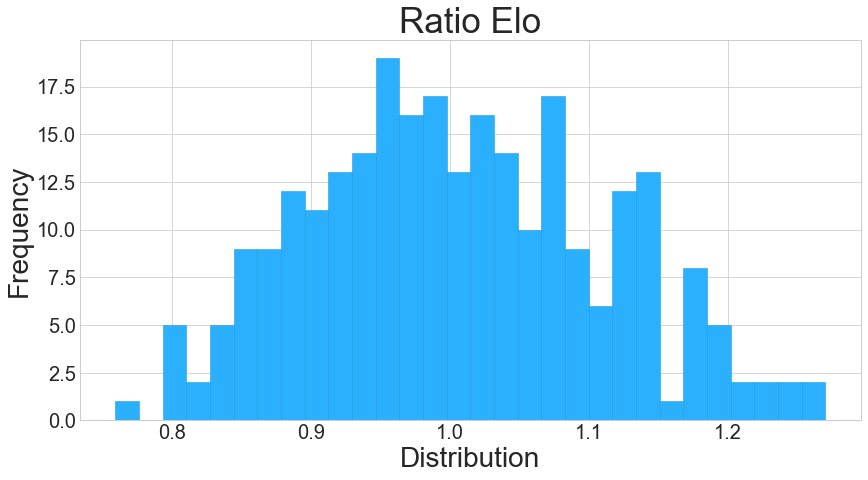

In [69]:
# Distribution ratio Elo

plt.figure(figsize=(14,7)) # Make it 14x7 inch

plt.style.use('seaborn-whitegrid') # nice and clean grid

plt.hist(Games['Elo_Home']/Games['Elo_Away'], bins=30, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)

plt.title('Ratio Elo', fontsize=35) 

plt.xlabel('Distribution', fontsize=28) 

plt.ylabel('Frequency', fontsize=28)

plt.xticks(fontsize=20)

plt.yticks(fontsize=20)

plt.show()

In [70]:
# Variable log_ratio_Elo

Games['ratio_Elo'] = Games['Elo_Home']/Games['Elo_Away']

In [71]:
# Save pandas for statistical inference in R

Games.to_csv("/Users/lorenzoleoni/Desktop/Materiale Personale/Statistical Analysis on Classification and Forecasting Models in Football/data/OLM_elo.csv",index=False)

## MAIN + CUP

In [72]:
# ORDERED LOGIT MODEL WITH ELO MAIN + CUP

Elo = OrderedLogit()

Regressors = Games[['log_ratio_ln_TM','Home_Performance','Away_Performance','ratio_Elo','Cup_Home','Cup_Away']]

Elo.fit(Regressors, Games['Winvalue'])

Elo.print_summary()

n=265
                    beta  se(beta)      p  lower 0.95  upper 0.95     
attribute names                                                       
log_ratio_ln_TM   1.2100    0.2651 0.0000      0.6903      1.7297  ***
Home_Performance -0.2850    0.1102 0.0097     -0.5010     -0.0691   **
Away_Performance  0.2851    0.1161 0.0140      0.0576      0.5125    *
ratio_Elo         0.3217    3.1508 0.9187     -5.8538      6.4972     
Cup_Home         -0.1518    0.3665 0.6787     -0.8702      0.5665     
Cup_Away         -0.0231    0.3744 0.9509     -0.7569      0.7108     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Somers' D = 0.407


In [73]:
# Predicted probabilities Main + Cup

Games['Aprob_Elo'] = 1/(1+np.exp(-(Elo.coef_[6]\
                               -Elo.coef_[0]*Games['log_ratio_ln_TM']\
                               -Elo.coef_[1]*Games['Home_Performance']\
                               -Elo.coef_[2]*Games['Away_Performance']\
                               -Elo.coef_[3]*Games['ratio_Elo']\
                               -Elo.coef_[4]*Games['Cup_Home']\
                               -Elo.coef_[5]*Games['Cup_Away'])))

Games['Dprob_Elo'] = 1/(1+np.exp(-(Elo.coef_[7]\
                               -Elo.coef_[0]*Games['log_ratio_ln_TM']\
                               -Elo.coef_[1]*Games['Home_Performance']\
                               -Elo.coef_[2]*Games['Away_Performance']\
                               -Elo.coef_[3]*Games['ratio_Elo']\
                               -Elo.coef_[4]*Games['Cup_Home']\
                               -Elo.coef_[5]*Games['Cup_Away'])))\
                               -Games['Aprob_Elo']

Games['Hprob_Elo'] = 1 - Games['Aprob_Elo'] - Games['Dprob_Elo']

In [74]:
# Result prediction Main + Cup

Maxprob = Games[['Aprob_Elo','Dprob_Elo','Hprob_Elo']].max(axis=1)

Games['Elo_pred']=np.where(Maxprob == Games['Aprob_Elo'],'A',\
                               np.where(Maxprob == Games['Dprob_Elo'],'D','H'))

In [75]:
# Confusion matrix Main + Cup

pd.crosstab(Games['Win'], Games['Elo_pred'],dropna= True)

Elo_pred,A,D,H
Win,,,
A,63,5,25
D,30,3,38
H,20,3,78


In [76]:
# Precision for model Elo Main + Cup

p_Elo = (63+3+78)/265

p_Elo

0.5433962264150943

## MAIN

In [77]:
# ORDERED LOGIT MODEL WITH ELO MAIN

Elo = OrderedLogit()

Regressors = Games[['log_ratio_ln_TM','Home_Performance','Away_Performance','ratio_Elo']]

Elo.fit(Regressors, Games['Winvalue'])

Elo.print_summary()

n=265
                    beta  se(beta)      p  lower 0.95  upper 0.95     
attribute names                                                       
log_ratio_ln_TM   1.2034    0.2645 0.0000      0.6851      1.7218  ***
Home_Performance -0.2882    0.1099 0.0087     -0.5036     -0.0729   **
Away_Performance  0.2760    0.1116 0.0134      0.0572      0.4947    *
ratio_Elo         0.2533    3.0991 0.9348     -5.8207      6.3274     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Somers' D = 0.406


In [78]:
# Predicted probabilities Main

Games['Aprob_Elo'] = 1/(1+np.exp(-(Elo.coef_[4]\
                               -Elo.coef_[0]*Games['log_ratio_ln_TM']\
                               -Elo.coef_[1]*Games['Home_Performance']\
                               -Elo.coef_[2]*Games['Away_Performance']\
                               -Elo.coef_[3]*Games['ratio_Elo'])))

Games['Dprob_Elo'] = 1/(1+np.exp(-(Elo.coef_[5]\
                               -Elo.coef_[0]*Games['log_ratio_ln_TM']\
                               -Elo.coef_[1]*Games['Home_Performance']\
                               -Elo.coef_[2]*Games['Away_Performance']\
                               -Elo.coef_[3]*Games['ratio_Elo'])))\
                               -Games['Aprob_Elo']

Games['Hprob_Elo'] = 1 - Games['Aprob_Elo'] - Games['Dprob_Elo']

In [79]:
# Result prediction Main

Maxprob = Games[['Aprob_Elo','Dprob_Elo','Hprob_Elo']].max(axis=1)

Games['Elo_pred']=np.where(Maxprob == Games['Aprob_Elo'],'A',\
                               np.where(Maxprob == Games['Dprob_Elo'],'D','H'))

In [80]:
# Confusion matrix Main

pd.crosstab(Games['Win'], Games['Elo_pred'],dropna= True)

Elo_pred,A,D,H
Win,,,
A,64,3,26
D,28,2,41
H,22,2,77


In [81]:
# Precision for model Elo Main

p_Elo = (64+2+77)/265

p_Elo

0.539622641509434

## MAIN + DIFF (Best)

In [82]:
# ORDERED LOGIT MODEL WITH ELO MAIN + DIFF

Elo = OrderedLogit()

Regressors = Games[['log_ratio_ln_TM','Home_Performance','Away_Performance','ratio_Elo','Home_Diff_Goals','Away_Diff_Goals']]

Elo.fit(Regressors, Games['Winvalue'])

Elo.print_summary()

n=265
                    beta  se(beta)      p  lower 0.95  upper 0.95     
attribute names                                                       
log_ratio_ln_TM   1.3005    0.2703 0.0000      0.7706      1.8304  ***
Home_Performance -0.2679    0.1313 0.0413     -0.5253     -0.0106    *
Away_Performance  0.2226    0.1249 0.0746     -0.0221      0.4673    .
ratio_Elo         2.7676    3.3321 0.4062     -3.7632      9.2983     
Home_Diff_Goals  -0.0275    0.0159 0.0834     -0.0587      0.0036    .
Away_Diff_Goals   0.0315    0.0167 0.0596     -0.0013      0.0644    .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Somers' D = 0.410


In [83]:
# Predicted probabilities Main + Diff

Games['Aprob_Elo'] = 1/(1+np.exp(-(Elo.coef_[6]\
                               -Elo.coef_[0]*Games['log_ratio_ln_TM']\
                               -Elo.coef_[1]*Games['Home_Performance']\
                               -Elo.coef_[2]*Games['Away_Performance']\
                               -Elo.coef_[3]*Games['ratio_Elo']\
                               -Elo.coef_[4]*Games['Home_Diff_Goals']\
                               -Elo.coef_[5]*Games['Away_Diff_Goals'])))

Games['Dprob_Elo'] = 1/(1+np.exp(-(Elo.coef_[7]\
                               -Elo.coef_[0]*Games['log_ratio_ln_TM']\
                               -Elo.coef_[1]*Games['Home_Performance']\
                               -Elo.coef_[2]*Games['Away_Performance']\
                               -Elo.coef_[3]*Games['ratio_Elo']\
                               -Elo.coef_[4]*Games['Home_Diff_Goals']\
                               -Elo.coef_[5]*Games['Away_Diff_Goals'])))\
                               -Games['Aprob_Elo']

Games['Hprob_Elo'] = 1 - Games['Aprob_Elo'] - Games['Dprob_Elo']

In [84]:
# Result prediction Main + Diff

Maxprob = Games[['Aprob_Elo','Dprob_Elo','Hprob_Elo']].max(axis=1)

Games['Elo_pred']=np.where(Maxprob == Games['Aprob_Elo'],'A',\
                               np.where(Maxprob == Games['Dprob_Elo'],'D','H'))

In [85]:
# Confusion matrix Main + Diff

pd.crosstab(Games['Win'], Games['Elo_pred'],dropna= True)

Elo_pred,A,D,H
Win,,,
A,68,5,20
D,25,6,40
H,23,1,77


In [86]:
# Precision for model Elo 

p_Elo = (68+6+77)/265

p_Elo

0.569811320754717

# Standings (ATTENTION! RUN A MODEL THAT WANT TO BE VISUALIZED FOR EACH SECTION)

In [87]:
# Variable Pts for home and away team

Odds['HPts'] = np.where(Odds['FTR']=='H',3,np.where(Odds['FTR']=='D',1,0))
Odds['APts'] = np.where(Odds['FTR']=='A',3,np.where(Odds['FTR']=='D',1,0))

In [88]:
# Variable Expected Pts for home and away team

Odds['xHPts'] = 3*Odds['Hprob_Odds'] + Odds['Dprob_Odds']
Odds['xAPts'] = 3*Odds['Aprob_Odds'] + Odds['Dprob_Odds']

In [89]:
# Standings for home games

Home_Teams = Odds.groupby('Home_Team')[['HPts','xHPts']].sum().reset_index()
Home_Games = Odds.groupby('Home_Team')['Date'].size().reset_index()
Home_Teams = pd.merge(Home_Teams,Home_Games, on = 'Home_Team')
Home_Teams.rename(columns={'HPts':'Pts','xHPts':'xPts','Home_Team':'Team', 'Date':'Games'},inplace=True)

In [90]:
# Standings for away games

Away_Teams = Odds.groupby('Away_Team')[['APts','xAPts']].sum().reset_index()
Away_Games = Odds.groupby('Away_Team')['Date'].size().reset_index()
Away_Teams = pd.merge(Away_Teams,Away_Games, on = 'Away_Team')
Away_Teams.rename(columns={'APts':'Pts','xAPts':'xPts','Away_Team':'Team','Date':'Games'},inplace=True)

In [91]:
# Standings

St_Odds = pd.merge(Home_Teams,Away_Teams,on='Team')
St_Odds['Pts'] = St_Odds['Pts_x'] + St_Odds['Pts_y']
St_Odds['xPts_Odds'] = St_Odds['xPts_x'] + St_Odds['xPts_y']
St_Odds['Games'] = St_Odds['Games_x'] + St_Odds['Games_y']
St_Odds.drop(['Pts_x','Pts_y','xPts_x','xPts_y','Games_x','Games_y'],axis=1,inplace=True)
St_Odds['Rank'] = pd.to_numeric(St_Odds['Pts'].rank(ascending=False),downcast='integer')
St_Odds['xRank_Odds'] = pd.to_numeric(St_Odds['xPts_Odds'].rank(ascending=False),downcast='integer')
St_Odds.sort_values(by='Pts',ascending=False,inplace=True)
G = St_Odds['Games']
St_Odds.drop('Games',axis=1,inplace=True)
St_Odds.insert(1,'Games',G)

In [92]:
# Variable xPts for home and away team model TMValue_Costant

St_TMValue_Costant = Games[['Home_Team','Away_Team','Aprob_TMValue_Costant','Dprob_TMValue_Costant','Hprob_TMValue_Costant']].copy()

St_TMValue_Costant['xHPts'] = 3*St_TMValue_Costant['Hprob_TMValue_Costant'] + St_TMValue_Costant['Dprob_TMValue_Costant']
St_TMValue_Costant['xAPts'] = 3*St_TMValue_Costant['Aprob_TMValue_Costant'] + St_TMValue_Costant['Dprob_TMValue_Costant']
St_TMValue_Costant.drop(['Aprob_TMValue_Costant','Dprob_TMValue_Costant','Hprob_TMValue_Costant'],axis=1,inplace=True)

In [93]:
# Standings for home games model TMValue_Costant

Home_Teams = St_TMValue_Costant.groupby('Home_Team')['xHPts'].sum().reset_index()
Home_Teams.rename(columns={'xHPts':'xPts','Home_Team':'Team'},inplace=True)

In [94]:
# Standings for away games model TMValue_Costant

Away_Teams = St_TMValue_Costant.groupby('Away_Team')['xAPts'].sum().reset_index()
Away_Teams.rename(columns={'xAPts':'xPts','Away_Team':'Team'},inplace=True)

In [95]:
# Standings

St_TMValue_Costant = pd.merge(Home_Teams,Away_Teams,on='Team')
St_TMValue_Costant['xPts_TMValue_Costant'] = St_TMValue_Costant['xPts_x'] + St_TMValue_Costant['xPts_y']
St_TMValue_Costant.drop(['xPts_x','xPts_y'],axis=1,inplace=True)
St_TMValue_Costant['xRank_TMValue_Costant'] = pd.to_numeric(St_TMValue_Costant['xPts_TMValue_Costant'].rank(ascending=False),downcast='integer')
St = pd.merge(St_Odds,St_TMValue_Costant,on='Team')
St.sort_values(by='Pts',ascending=False,inplace=True)

In [96]:
# Variable xPts for home and away team model TMValue_Lineups

St_TMValue_Lineups = Games[['Home_Team','Away_Team','Aprob_TMValue_Lineups','Dprob_TMValue_Lineups','Hprob_TMValue_Lineups']].copy()

St_TMValue_Lineups['xHPts'] = 3*St_TMValue_Lineups['Hprob_TMValue_Lineups'] + St_TMValue_Lineups['Dprob_TMValue_Lineups']
St_TMValue_Lineups['xAPts'] = 3*St_TMValue_Lineups['Aprob_TMValue_Lineups'] + St_TMValue_Lineups['Dprob_TMValue_Lineups']
St_TMValue_Lineups.drop(['Aprob_TMValue_Lineups','Dprob_TMValue_Lineups','Hprob_TMValue_Lineups'],axis=1,inplace=True)

In [97]:
# Standings for home games model TMValue_Lineups

Home_Teams = St_TMValue_Lineups.groupby('Home_Team')['xHPts'].sum().reset_index()
Home_Teams.rename(columns={'xHPts':'xPts','Home_Team':'Team'},inplace=True)

In [98]:
# Standings for away games model TMValue_Lineups

Away_Teams = St_TMValue_Lineups.groupby('Away_Team')['xAPts'].sum().reset_index()
Away_Teams.rename(columns={'xAPts':'xPts','Away_Team':'Team'},inplace=True)

In [99]:
# Standings

St_TMValue_Lineups = pd.merge(Home_Teams,Away_Teams,on='Team')
St_TMValue_Lineups['xPts_TMValue_Lineups'] = St_TMValue_Lineups['xPts_x'] + St_TMValue_Lineups['xPts_y']
St_TMValue_Lineups.drop(['xPts_x','xPts_y'],axis=1,inplace=True)
St_TMValue_Lineups['xRank_TMValue_Lineups'] = pd.to_numeric(St_TMValue_Lineups['xPts_TMValue_Lineups'].rank(ascending=False),downcast='integer')
St = pd.merge(St,St_TMValue_Lineups,on='Team')
St.sort_values(by='Pts',ascending=False,inplace=True)

In [100]:
# Variable xPts for home and away team model Elo

St_Elo = Games[['Home_Team','Away_Team','Aprob_Elo','Dprob_Elo','Hprob_Elo']].copy()

St_Elo['xHPts'] = 3*St_Elo['Hprob_Elo'] + St_Elo['Dprob_Elo']
St_Elo['xAPts'] = 3*St_Elo['Aprob_Elo'] + St_Elo['Dprob_Elo']
St_Elo.drop(['Aprob_Elo','Dprob_Elo','Hprob_Elo'],axis=1,inplace=True)

In [101]:
# Standings for home games model TMValue_Lineups

Home_Teams = St_Elo.groupby('Home_Team')['xHPts'].sum().reset_index()
Home_Teams.rename(columns={'xHPts':'xPts','Home_Team':'Team'},inplace=True)

In [102]:
# Standings for away games model TMValue_Lineups

Away_Teams = St_Elo.groupby('Away_Team')['xAPts'].sum().reset_index()
Away_Teams.rename(columns={'xAPts':'xPts','Away_Team':'Team'},inplace=True)

In [103]:
# Standings

St_Elo = pd.merge(Home_Teams,Away_Teams,on='Team')
St_Elo['xPts_Elo'] = St_Elo['xPts_x'] + St_Elo['xPts_y']
St_Elo.drop(['xPts_x','xPts_y'],axis=1,inplace=True)
St_Elo['xRank_Elo'] = pd.to_numeric(St_Elo['xPts_Elo'].rank(ascending=False),downcast='integer')
St = pd.merge(St,St_Elo,on='Team')
St.sort_values(by='Pts',ascending=False,inplace=True)
St

,Team,Games,Pts,xPts_Odds,Rank,xRank_Odds,xPts_TMValue_Costant,xRank_TMValue_Costant,xPts_TMValue_Lineups,xRank_TMValue_Lineups,xPts_Elo,xRank_Elo
0,Milan,27,57,48.687660,1.5,5,50.890704,4,48.397513,5,48.662720,5
1,Napoli,27,57,51.380790,1.5,3,53.929471,2,50.296649,4,50.329152,3
2,Internazionale,26,55,53.179072,3.0,1,51.242381,3,50.317500,3,51.421257,2
3,Juventus,27,50,51.910297,4.0,2,55.240921,1,52.294346,1,53.871284,1
4,Atalanta,26,47,48.735258,5.0,4,46.356612,6,44.954318,8,46.546974,7
5,Roma,27,44,46.463189,6.0,6,50.181265,5,50.387234,2,49.665826,4
6,Lazio,27,43,42.760948,7.0,7,41.388040,8,45.803424,7,45.613840,8
7,Fiorentina,26,42,39.247657,8.0,8,35.652961,10,40.210554,9,38.453102,9
8,Hellas Verona,27,40,36.706610,9.0,9,30.881793,13,33.857680,12,33.248933,12
9,Sassuolo,27,36,36.562678,10.0,10,42.698013,7,46.983342,6,47.278903,6


In [104]:
# Variables Score for each model

St['Score_Odds'] = [0]*len(St)

St['Score_TMValue_Costant'] = [0]*len(St)

St['Score_TMValue_Lineups'] = [0]*len(St)

St['Score_Elo'] = [0]*len(St)

In [105]:
# Calculation Score

i = 0

for i in range(0,len(St)):
    
    if St.loc[i,'Rank'] == 1.5:
    
        if abs(St.loc[i,'Rank']-St.loc[i,'xRank_Odds']) <= 1:
            St.loc[i,'Score_Odds'] = 20
        else:
            St.loc[i,'Score_Odds'] = 20 - abs(St.loc[i,'Rank']-St.loc[i,'xRank_Odds'])
            
        if abs(St.loc[i,'Rank']-St.loc[i,'xRank_TMValue_Costant']) <= 1:
            St.loc[i,'Score_TMValue_Costant'] = 20
        else:
            St.loc[i,'Score_TMValue_Costant'] = 20 - abs(St.loc[i,'Rank']-St.loc[i,'xRank_TMValue_Costant'])
            
        if abs(St.loc[i,'Rank']-St.loc[i,'xRank_TMValue_Lineups']) <= 1:
            St.loc[i,'Score_TMValue_Lineups'] = 20
        else:
            St.loc[i,'Score_TMValue_Lineups'] = 20 - abs(St.loc[i,'Rank']-St.loc[i,'xRank_TMValue_Lineups'])
            
        if abs(St.loc[i,'Rank']-St.loc[i,'xRank_Elo']) <= 1:
            St.loc[i,'Score_Elo'] = 20
        else:
            St.loc[i,'Score_Elo'] = 20 - abs(St.loc[i,'Rank']-St.loc[i,'xRank_Elo'])
            
    if St.loc[i,'Rank'] == 15:
    
        if (St.loc[i,'xRank_Odds'] >= 14) & (St.loc[i,'xRank_Odds'] <= 16):
            St.loc[i,'Score_Odds'] = 20
        else:
            St.loc[i,'Score_Odds'] = 20 - abs(St.loc[i,'Rank']-St.loc[i,'xRank_Odds'])
            
        if (St.loc[i,'xRank_TMValue_Costant'] >= 14) & (St.loc[i,'xRank_TMValue_Costant'] <= 16):
            St.loc[i,'Score_TMValue_Costant'] = 20
        else:
            St.loc[i,'Score_TMValue_Costant'] = 20 - abs(St.loc[i,'Rank']-St.loc[i,'xRank_TMValue_Costant'])
            
        if (St.loc[i,'xRank_TMValue_Lineups'] >= 14) & (St.loc[i,'xRank_TMValue_Lineups'] <= 16):
            St.loc[i,'Score_TMValue_Lineups'] = 20
        else:
            St.loc[i,'Score_TMValue_Lineups'] = 20 - abs(St.loc[i,'Rank']-St.loc[i,'xRank_TMValue_Lineups'])
            
        if (St.loc[i,'xRank_Elo'] >= 14) & (St.loc[i,'xRank_Elo'] <= 16):
            St.loc[i,'Score_Elo'] = 20
        else:
            St.loc[i,'Score_Elo'] = 20 - abs(St.loc[i,'Rank']-St.loc[i,'xRank_Elo'])
                                       
    else:
        
        St.loc[i,'Score_Odds'] = 20 - abs(St.loc[i,'Rank']-St.loc[i,'xRank_Odds'])
        St.loc[i,'Score_TMValue_Costant'] = 20 - abs(St.loc[i,'Rank']-St.loc[i,'xRank_TMValue_Costant'])
        St.loc[i,'Score_TMValue_Lineups'] = 20 - abs(St.loc[i,'Rank']-St.loc[i,'xRank_TMValue_Lineups'])
        St.loc[i,'Score_Elo'] = 20 - abs(St.loc[i,'Rank']-St.loc[i,'xRank_Elo'])

In [106]:
# Score Model Odds

St['Score_Odds'].sum()

380.0

In [107]:
# Score Model TMValue_Costant

St['Score_TMValue_Costant'].sum()

356.0

In [108]:
# Score Model TMValue_Lineups

St['Score_TMValue_Lineups'].sum()

358.0

In [109]:
# Score Model Elo

St['Score_Elo'].sum()

361.0

# Generilzed Linear Models for npxG_Expected

In [110]:
Milan = Games[(Games['Home_Team']=='Milan')|(Games['Away_Team']=='Milan')].copy()

Milan = Milan.reset_index(drop = True)

Milan.head()

,Matchweek,Match_Date,Home_Team,Away_Team,Win,log_ratio_Value,Cup_Home,Cup_Away,Winvalue,Home_Performance,...,Dprob_TMValue_Lineups,Hprob_TMValue_Lineups,TMValue_Lineups_pred,Elo_Home,Elo_Away,ratio_Elo,Aprob_Elo,Dprob_Elo,Hprob_Elo,Elo_pred
0,1,2021-08-23,Sampdoria,Milan,A,-1.507835,0,0,0,0.0,...,0.143866,0.056546,A,1640.594971,1798.833252,0.912033,0.805652,0.139977,0.054371,A
1,2,2021-08-29,Milan,Cagliari,H,1.281791,0,0,2,1.0,...,0.198453,0.714222,H,1805.029419,1584.489502,1.139187,0.076849,0.182004,0.741147,H
2,3,2021-09-12,Milan,Lazio,H,0.556540,0,0,2,2.0,...,0.292690,0.535550,H,1809.420410,1743.203247,1.037986,0.169311,0.291642,0.539047,H
3,4,2021-09-19,Juventus,Milan,D,0.193828,1,1,1,-2.0,...,0.326130,0.441960,H,1823.406128,1810.558350,1.007096,0.201486,0.312755,0.485759,H
4,5,2021-09-22,Milan,Venezia,H,1.670069,0,0,2,1.5,...,0.151150,0.788615,H,1812.065918,1482.718750,1.222124,0.050584,0.132111,0.817305,H


In [111]:
# Subset games to exctract milan and opponent usefull statistics

SerieA_Milan = SerieA[(SerieA.loc[:,'Home_Team']=='Milan')|(SerieA.loc[:,'Away_Team']=='Milan')].copy()
SerieA_Milan.sort_values(by='Matchweek',inplace=True)
SerieA_Milan.reset_index(drop=True, inplace=True)

In [112]:
SerieA_Milan.to_csv('/Users/lorenzoleoni/Desktop/Materiale Personale/Statistical Analysis on Classification and Forecasting Models in Football/data/SerieA_Milan.csv',index=False)

In [113]:
# Exctraction usefull statistics

Milan.loc[:,'Home_Away'] = np.where(Milan.loc[:,'Home_Team']=='Milan','H','A')

i = 0

k = 0

Milan['npxG_Expected'] = [0]*len(Milan)

Milan['Cmp_percent_Passes'] = [0]*len(Milan)

Milan['Att_Dribbles'] = [0]*len(Milan)

Milan['Str_Corner_Kicks'] = [0]*len(Milan)

Milan['Def_Touches'] = [0]*len(Milan)

Milan['Att_Pressures'] = [0]*len(Milan)

Milan['Opponent_percent_Pressures'] = [0]*len(Milan)

Milan['Opponent_Att_Long'] = [0]*len(Milan)

Milan['Fls'] = [0]*len(Milan)

while k < max(SerieA_Milan['Matchweek']):
        
    if SerieA_Milan.loc[i,'Team']!='Milan':
        
        Milan.loc[k,'Opponent_percent_Pressures'] = SerieA_Milan[(SerieA_Milan['Matchweek']==k+1)&(SerieA_Milan['Team']!='Milan')]['percent_Pressures'].iloc[0]
        
        Milan.loc[k,'Cmp_percent_Passes'] = SerieA_Milan[(SerieA_Milan['Matchweek']==k+1)&(SerieA_Milan['Team']=='Milan')]['Cmp_percent_Passes'].iloc[0]
       
        Milan.loc[k,'npxG_Expected'] = SerieA_Milan[(SerieA_Milan['Matchweek']==k+1)&(SerieA_Milan['Team']=='Milan')]['npxG_Expected'].iloc[0]
        
        Milan.loc[k,'Att_Pressures'] = SerieA_Milan[(SerieA_Milan['Matchweek']==k+1)&(SerieA_Milan['Team']=='Milan')]['Att 3rd_Pressures'].iloc[0]
        
        Milan.loc[k,'Att_Dribbles'] = SerieA_Milan[(SerieA_Milan['Matchweek']==k+1)&(SerieA_Milan['Team']=='Milan')]['Att_Dribbles'].iloc[0]
        
        Milan.loc[k,'Str_Corner_Kicks'] = SerieA_Milan[(SerieA_Milan['Matchweek']==k+1)&(SerieA_Milan['Team']=='Milan')]['Str_Corner_Kicks'].iloc[0]
        
        Milan.loc[k,'Def_Touches'] = SerieA_Milan[(SerieA_Milan['Matchweek']==k+1)&(SerieA_Milan['Team']=='Milan')]['Def 3rd_Touches'].iloc[0]
        
        Milan.loc[k,'Fls'] = SerieA_Milan[(SerieA_Milan['Matchweek']==k+1)&(SerieA_Milan['Team']=='Milan')]['Fls_9'].iloc[0]
        
        Milan.loc[k,'Opponent_Att_Long'] = SerieA_Milan[(SerieA_Milan['Matchweek']==k+1)&(SerieA_Milan['Team']!='Milan')]['Att_Long'].iloc[0]
        
        k += 1
        
    i += 1

Milan.head()

,Matchweek,Match_Date,Home_Team,Away_Team,Win,log_ratio_Value,Cup_Home,Cup_Away,Winvalue,Home_Performance,...,Home_Away,npxG_Expected,Cmp_percent_Passes,Att_Dribbles,Str_Corner_Kicks,Def_Touches,Att_Pressures,Opponent_percent_Pressures,Opponent_Att_Long,Fls
0,1,2021-08-23,Sampdoria,Milan,A,-1.507835,0,0,0,0.0,...,A,1.1,79.0,17,0,200,47,30.1,92,15
1,2,2021-08-29,Milan,Cagliari,H,1.281791,0,0,2,1.0,...,H,2.0,88.1,20,0,197,34,21.4,64,15
2,3,2021-09-12,Milan,Lazio,H,0.556540,0,0,2,2.0,...,H,2.3,82.7,26,0,197,41,23.1,60,12
3,4,2021-09-19,Juventus,Milan,D,0.193828,1,1,1,-2.0,...,A,0.7,86.9,17,0,160,32,32.1,101,16
4,5,2021-09-22,Milan,Venezia,H,1.670069,0,0,2,1.5,...,H,1.7,86.7,31,0,197,50,27.3,77,15


In [114]:
# Save variables for Milan and Opponent in each match

i = 0

Milan['Milan_Performance'] = [0]*len(Milan)

Milan['Opponent_Performance'] = [0]*len(Milan)

Milan['Milan_Elo'] = [0]*len(Milan)

Milan['Opponent_Elo'] = [0]*len(Milan)

Milan['Milan_Cup'] = [0]*len(Milan)

Milan['Opponent_Cup'] = [0]*len(Milan)

Milan['Milan_Diff_Goals'] = [0]*len(Milan)

Milan['Opponent_Diff_Goals'] = [0]*len(Milan)

Milan['Opponent_ln_TM'] = [0]*len(Milan)

Milan['Milan_ln_TM'] = [0]*len(Milan)

for i in range(0,len(Milan)):

    Milan.loc[i,'Milan_Performance'] = np.where(Milan.loc[i,'Home_Team']=='Milan',\
                                                  Milan.loc[i,'Home_Performance'], \
                                                  Milan.loc[i,'Away_Performance'])

    Milan.loc[i,'Opponent_Performance'] = np.where(Milan.loc[i,'Home_Team']!='Milan',\
                                                  Milan.loc[i,'Home_Performance'], \
                                                  Milan.loc[i,'Away_Performance'])
    
    Milan.loc[i,'Milan_Elo'] = np.where(Milan.loc[i,'Home_Team']=='Milan',\
                                                  Milan.loc[i,'Elo_Home'], \
                                                  Milan.loc[i,'Elo_Away'])

    Milan.loc[i,'Opponent_Elo'] = np.where(Milan.loc[i,'Home_Team']!='Milan',\
                                                  Milan.loc[i,'Elo_Home'], \
                                                  Milan.loc[i,'Elo_Away'])
    
    Milan.loc[i,'Milan_Cup'] = np.where(Milan.loc[i,'Home_Team']=='Milan',\
                                                  Milan.loc[i,'Cup_Home'], \
                                                  Milan.loc[i,'Cup_Away'])
    
    Milan.loc[i,'Opponent_Cup'] = np.where(Milan.loc[i,'Home_Team']!='Milan',\
                                                  Milan.loc[i,'Cup_Home'], \
                                                  Milan.loc[i,'Cup_Away'])
    
    Milan.loc[i,'Milan_ln_TM'] = np.where(Milan.loc[i,'Home_Team']=='Milan',\
                                                  Milan.loc[i,'ln_TM_Home'], \
                                                  Milan.loc[i,'ln_TM_Away'])
    
    Milan.loc[i,'Opponent_ln_TM'] = np.where(Milan.loc[i,'Home_Team']!='Milan',\
                                                  Milan.loc[i,'ln_TM_Home'], \
                                                  Milan.loc[i,'ln_TM_Away'])
    
    Milan.loc[i,'Milan_Diff_Goals'] = np.where(Milan.loc[i,'Home_Team']=='Milan',\
                                                  Milan.loc[i,'Home_Diff_Goals'], \
                                                  Milan.loc[i,'Away_Diff_Goals'])
    
    Milan.loc[i,'Opponent_Diff_Goals'] = np.where(Milan.loc[i,'Home_Team']!='Milan',\
                                                  Milan.loc[i,'Home_Diff_Goals'], \
                                                  Milan.loc[i,'Away_Diff_Goals'])
            
Milan['log_ratio_ln_TM'] = np.log(Milan['Milan_ln_TM']) - np.log(Milan['Opponent_ln_TM'])
Milan['ratio_Elo'] = Milan['Milan_Elo']/Milan['Opponent_Elo']
Milan.drop(['Cup_Home','Cup_Away','Home_Performance','Away_Performance','ln_TM_Home',\
            'ln_TM_Away','Elo_Home','Elo_Away','Home_Diff_Goals','Away_Diff_Goals',\
            'Aprob_TMValue_Costant','Dprob_TMValue_Costant','Hprob_TMValue_Costant',\
           'TMValue_Costant_pred','Aprob_TMValue_Lineups','Dprob_TMValue_Lineups',\
           'Hprob_TMValue_Lineups','TMValue_Lineups_pred','Aprob_Elo','Dprob_Elo',\
            'Hprob_Elo','Elo_pred'], axis=1,inplace=True)
Milan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Matchweek                   27 non-null     int64         
 1   Match_Date                  27 non-null     datetime64[ns]
 2   Home_Team                   27 non-null     object        
 3   Away_Team                   27 non-null     object        
 4   Win                         27 non-null     object        
 5   log_ratio_Value             27 non-null     float64       
 6   Winvalue                    27 non-null     int64         
 7   log_ratio_ln_TM             27 non-null     float64       
 8   ratio_Elo                   27 non-null     float64       
 9   Home_Away                   27 non-null     object        
 10  npxG_Expected               27 non-null     float64       
 11  Cmp_percent_Passes          27 non-null     float64       
 

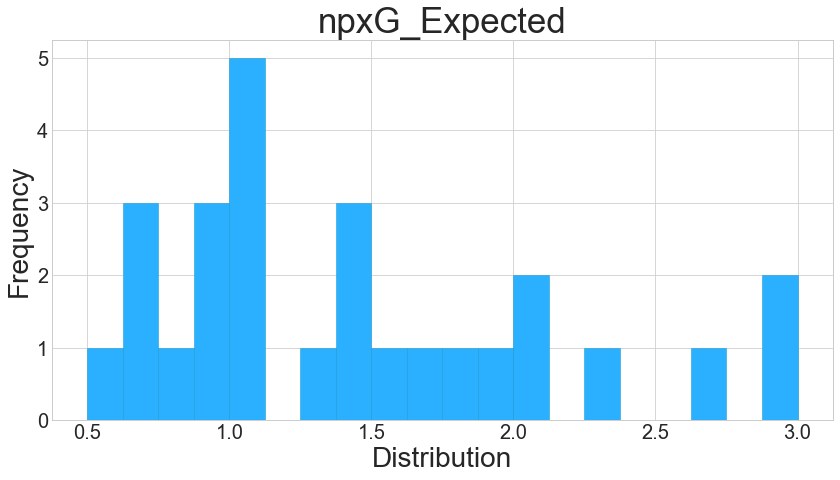

In [115]:
# Distribution npxG_Expected

plt.figure(figsize=(14,7)) # Make it 14x7 inch

plt.style.use('seaborn-whitegrid') # nice and clean grid

plt.hist(Milan['npxG_Expected'], bins=20, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)

plt.title('npxG_Expected', fontsize=35) 

plt.xlabel('Distribution', fontsize=28) 

plt.ylabel('Frequency', fontsize=28)

plt.xticks(fontsize=20)

plt.yticks(fontsize=20)

plt.show()

## FORWARD SELECTION

In [116]:
# Train data first half of the season

train_data = Milan.loc[(Milan['Matchweek']<=19).values].copy()
train_data.drop(['Matchweek','Match_Date','Home_Team','Away_Team','Win','Winvalue','Home_Away',\
                 'Milan_Elo','Opponent_Elo','Opponent_ln_TM','Milan_ln_TM'], axis=1, inplace=True)

In [117]:
# Create gamma regression object

mod = GammaRegressor()

In [118]:
# Forward Selection

forward_selection = sfs(mod, k_features=5, forward=True, floating=True, verbose=2, scoring='neg_mean_gamma_deviance')
forward_selection = forward_selection.fit(train_data.loc[:, train_data.columns != 'npxG_Expected'],train_data['npxG_Expected'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.2s finished

[2022-03-22 16:32:01] Features: 1/5 -- score: -0.1009827230817087[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished

[2022-03-22 16:32:02] Features: 2/5 -- score: -0.08426709323266159[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_j

In [119]:
# Features selected

feat_names = list(forward_selection.k_feature_names_)
print(feat_names)

['ratio_Elo', 'Def_Touches', 'Att_Pressures', 'Opponent_percent_Pressures', 'Milan_Performance']


In [120]:
# Gamma regression with the features selected

npxG_for = smf.glm(formula='npxG_Expected ~ ratio_Elo + Def_Touches + Att_Pressures + Opponent_percent_Pressures + Milan_Performance', data = train_data, \
             family=sm.families.Gamma(link=sm.families.links.log())).fit()
print(npxG_for.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          npxG_Expected   No. Observations:                   19
Model:                            GLM   Df Residuals:                       13
Model Family:                   Gamma   Df Model:                            5
Link Function:                    log   Scale:                        0.077166
Method:                          IRLS   Log-Likelihood:                -3.7834
Date:                Tue, 22 Mar 2022   Deviance:                      0.89606
Time:                        16:32:03   Pearson chi2:                     1.00
No. Iterations:                    14   Pseudo R-squ. (CS):             0.9113
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [121]:
# AIC model forward selectiom

npxG_for.aic

19.56687098958789

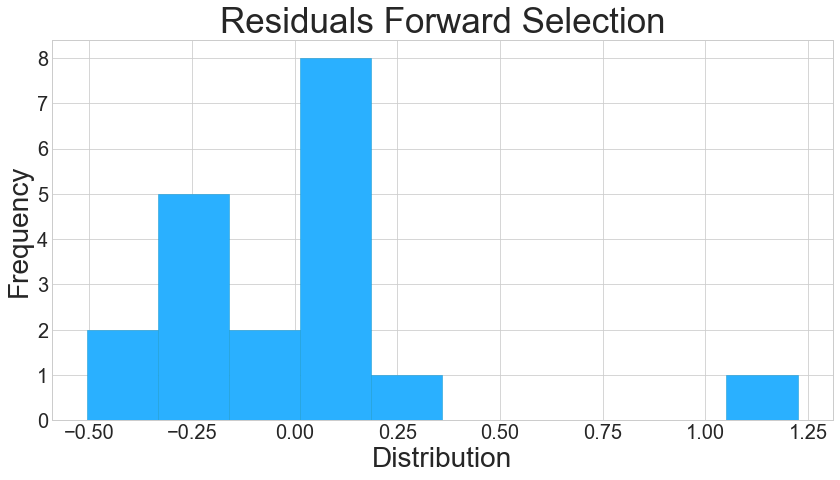

In [122]:
# Distribution residuals from model npxG_Expected forward selection

plt.figure(figsize=(14,7)) # Make it 14x7 inch

plt.style.use('seaborn-whitegrid') # nice and clean grid

plt.hist(npxG_for.resid_response, bins=10, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)

plt.title('Residuals Forward Selection', fontsize=35) 

plt.xlabel('Distribution', fontsize=28) 

plt.ylabel('Frequency', fontsize=28)

plt.xticks(fontsize=20)

plt.yticks(fontsize=20)

plt.show()

In [123]:
# Shapiro-Wilk test, H0 : Normal Residuals

shapiro(npxG_for.resid_response)

ShapiroResult(statistic=0.7880101203918457, pvalue=0.0007692936924286187)

In [124]:
# Test data

test_data = Milan.loc[(Milan['Matchweek']>19).values].copy()

In [125]:
# Prediction of npxG_Expected from test dataset

test_data['npxG_pred'] = npxG_for.predict(test_data)
test_data[['npxG_Expected','npxG_pred']]

,npxG_Expected,npxG_pred
19,1.4,0.690440
20,2.7,1.194978
21,1.8,1.305310
22,0.7,0.988338
23,1.4,1.124090
24,1.5,1.210538
25,1.3,0.905569
26,0.7,1.146882


In [126]:
# Deviance model npxG

D_npxG_for = mean_gamma_deviance(test_data['npxG_Expected'],test_data['npxG_pred'])
D_npxG_for

0.2761789535697918

## GAMMA REGRESSION (Best)

In [127]:
# Features selected from the forward selection and correlation with r, if it's used the canonical link function (inverse power) we obtain a better CS and deviance but a 
# not a theoretically correct model

npxG = smf.glm(formula='npxG_Expected ~ Opponent_percent_Pressures*Def_Touches + Att_Pressures + Milan_Performance + Milan_Cup', data = train_data, \
             family=sm.families.Gamma(link=sm.families.links.log())).fit()
print(npxG.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          npxG_Expected   No. Observations:                   19
Model:                            GLM   Df Residuals:                       12
Model Family:                   Gamma   Df Model:                            6
Link Function:                    log   Scale:                        0.057378
Method:                          IRLS   Log-Likelihood:               -0.87703
Date:                Tue, 22 Mar 2022   Deviance:                      0.65937
Time:                        16:32:03   Pearson chi2:                    0.689
No. Iterations:                    11   Pseudo R-squ. (CS):             0.9690
Covariance Type:            nonrobust                                         
                                             coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [128]:
# AIC model gamma regression

npxG.aic

15.754059936820369

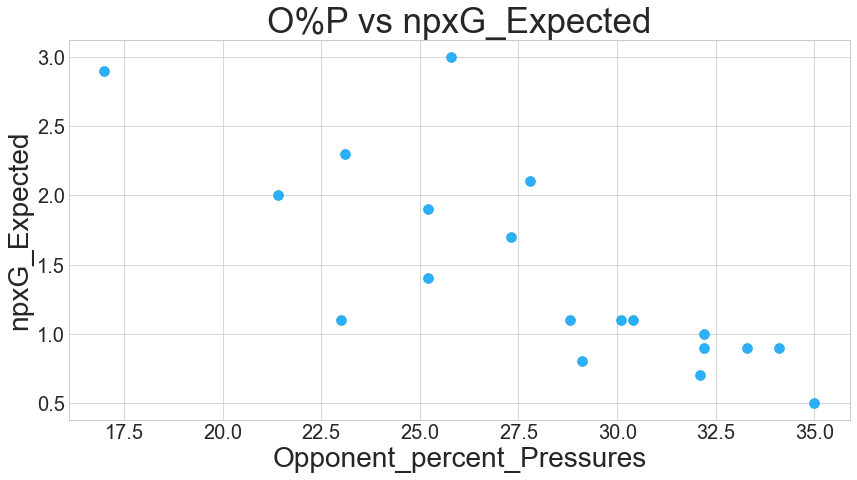

In [129]:
# Distribution Observation Opponent_percent_Pressures vs npxG_Expected

plt.figure(figsize=(14,7)) # Make it 14x7 inch

plt.style.use('seaborn-whitegrid') # nice and clean grid

plt.scatter(train_data['Opponent_percent_Pressures'], train_data['npxG_Expected'], s = 100, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)

plt.title('O%P vs npxG_Expected', fontsize=35) 

plt.xlabel('Opponent_percent_Pressures', fontsize=28) 

plt.ylabel('npxG_Expected', fontsize=28)

plt.xticks(fontsize=20)

plt.yticks(fontsize=20)

plt.show()

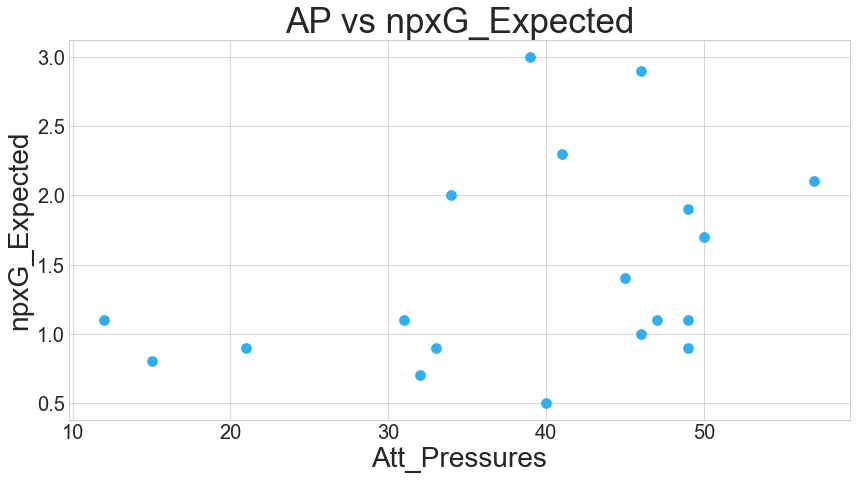

In [130]:
# Distribution Observation Opponent_percent_Pressures vs npxG_Expected

plt.figure(figsize=(14,7)) # Make it 14x7 inch

plt.style.use('seaborn-whitegrid') # nice and clean grid

plt.scatter(train_data['Att_Pressures'], train_data['npxG_Expected'], s = 100, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)

plt.title('AP vs npxG_Expected', fontsize=35) 

plt.xlabel('Att_Pressures', fontsize=28) 

plt.ylabel('npxG_Expected', fontsize=28)

plt.xticks(fontsize=20)

plt.yticks(fontsize=20)

plt.show()

In [131]:
# Shapiro-Wilk test, H0 : Normal Residuals

shapiro(npxG.resid_response)

ShapiroResult(statistic=0.8968127965927124, pvalue=0.042617324739694595)

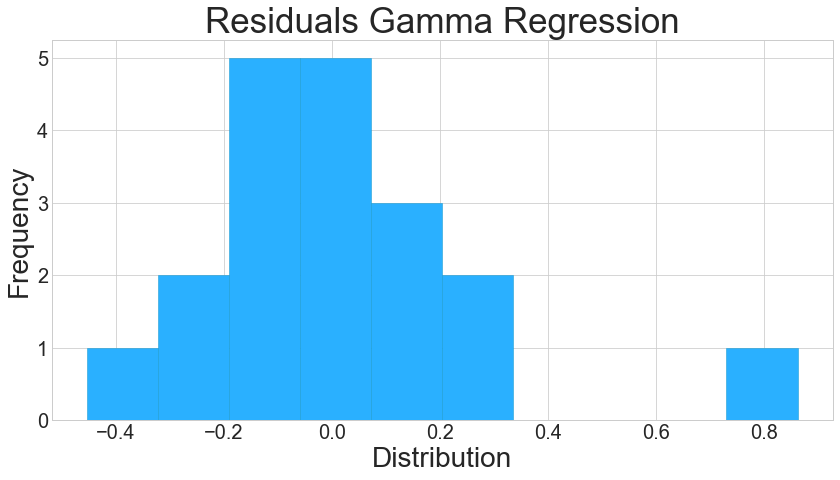

In [132]:
# Residuals distribution from the model gamma regression

plt.figure(figsize=(14,7)) # Make it 14x7 inch

plt.style.use('seaborn-whitegrid') # nice and clean grid

plt.hist(npxG.resid_response, bins = 10, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)

plt.title('Residuals Gamma Regression', fontsize=35) 

plt.xlabel('Distribution', fontsize=28) 

plt.ylabel('Frequency', fontsize=28)

plt.xticks(fontsize=20)

plt.yticks(fontsize=20)

plt.show()

In [133]:
# Test data

test_data = Milan.loc[(Milan['Matchweek']>19).values].copy()

In [134]:
# Prediction of npxG_Expected from test dataset

test_data['npxG_pred'] = npxG.predict(test_data)
test_data[['npxG_Expected','npxG_pred']]

,npxG_Expected,npxG_pred
19,1.4,0.759713
20,2.7,1.821432
21,1.8,1.640999
22,0.7,0.853408
23,1.4,1.074074
24,1.5,1.340863
25,1.3,0.738110
26,0.7,1.073692


In [135]:
# Deviance model npxG

D_npxG = mean_gamma_deviance(test_data['npxG_Expected'],test_data['npxG_pred'])
D_npxG

0.16574353711445594

## OUTLIER REMOVAL

In [136]:
# Drop the outlier with the residual value above 0.7 in train data

train_data.drop(np.where(npxG.resid_response > 0.7)[0][0], axis=0,inplace=True)

In [137]:
# Features selected from the forward selection and correlation with r, if it's used the canonical link function (inverse power) we obtain a better CS and deviance but a 
# not a theoretically correct model

npxG_res = smf.glm(formula='npxG_Expected ~ Opponent_percent_Pressures*Def_Touches + Def_Touches + Att_Pressures + Milan_Performance + Milan_Cup', data = train_data, \
             family=sm.families.Gamma(link=sm.families.links.log())).fit()
print(npxG_res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          npxG_Expected   No. Observations:                   18
Model:                            GLM   Df Residuals:                       11
Model Family:                   Gamma   Df Model:                            6
Link Function:                    log   Scale:                        0.038379
Method:                          IRLS   Log-Likelihood:                 3.6814
Date:                Tue, 22 Mar 2022   Deviance:                      0.41668
Time:                        16:32:04   Pearson chi2:                    0.422
No. Iterations:                    12   Pseudo R-squ. (CS):             0.9912
Covariance Type:            nonrobust                                         
                                             coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [138]:
# AIC model outlier removal

npxG_res.aic

6.637158711678339

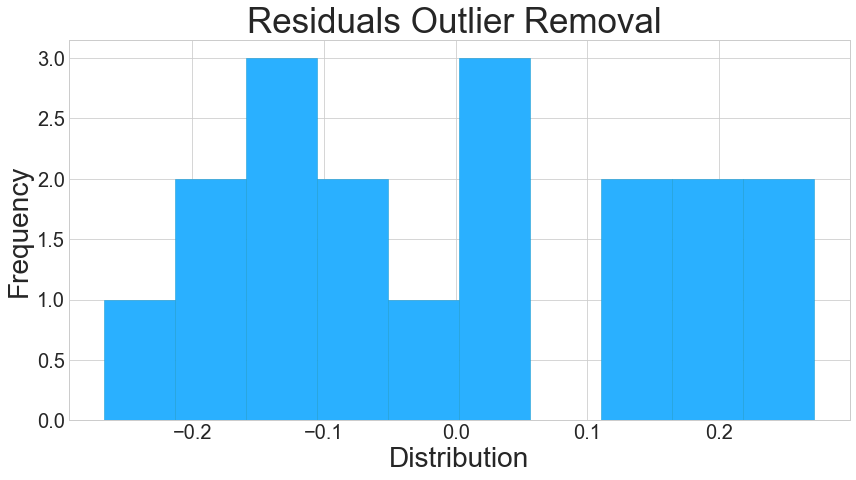

In [139]:
# Distribution residuals from model outlier removal

plt.figure(figsize=(14,7)) # Make it 14x7 inch

plt.style.use('seaborn-whitegrid') # nice and clean grid

plt.hist(npxG_res.resid_response, bins=10, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)

plt.title('Residuals Outlier Removal ', fontsize=35) 

plt.xlabel('Distribution', fontsize=28) 

plt.ylabel('Frequency', fontsize=28)

plt.xticks(fontsize=20)

plt.yticks(fontsize=20)

plt.show()

In [140]:
# Shapiro-Wilk test, H0 : Normal Residuals

shapiro(npxG_res.resid_response)

ShapiroResult(statistic=0.9502063393592834, pvalue=0.42826229333877563)

In [141]:
# Test data

test_data = Milan.loc[(Milan['Matchweek']>19).values].copy()

In [142]:
# Prediction of npxG_Expected from test dataset

test_data['npxG_pred'] = npxG_res.predict(test_data)
test_data[['npxG_Expected','npxG_pred']]

,npxG_Expected,npxG_pred
19,1.4,0.718050
20,2.7,1.311641
21,1.8,1.261842
22,0.7,0.960315
23,1.4,1.117067
24,1.5,1.128428
25,1.3,0.852940
26,0.7,1.121664


In [143]:
# Deviance model npxG_res

D_npxG_res = mean_gamma_deviance(test_data['npxG_Expected'],test_data['npxG_pred'])
D_npxG_res

0.251341060263988

## INVERSE GAUSSIAN

In [144]:
# Train data

train_data = Milan.loc[(Milan['Matchweek']<=19).values].copy()

In [145]:
# Features selected from the forward selection and correlation with r, if it's used the canonical link function (inverse power) we obtain a better CS and deviance but a 
# not a theoretically correct model

npxG_inv = smf.glm(formula='npxG_Expected ~ Opponent_percent_Pressures*Def_Touches + Att_Pressures + Milan_Performance + Milan_Cup', data = train_data, \
             family=sm.families.InverseGaussian(link=sm.families.links.log())).fit()
print(npxG.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          npxG_Expected   No. Observations:                   19
Model:                            GLM   Df Residuals:                       12
Model Family:                   Gamma   Df Model:                            6
Link Function:                    log   Scale:                        0.057378
Method:                          IRLS   Log-Likelihood:               -0.87703
Date:                Tue, 22 Mar 2022   Deviance:                      0.65937
Time:                        16:32:04   Pearson chi2:                    0.689
No. Iterations:                    11   Pseudo R-squ. (CS):             0.9690
Covariance Type:            nonrobust                                         
                                             coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [146]:
# AIC model inverse Gaussian

npxG_inv.aic

18.24618233608377

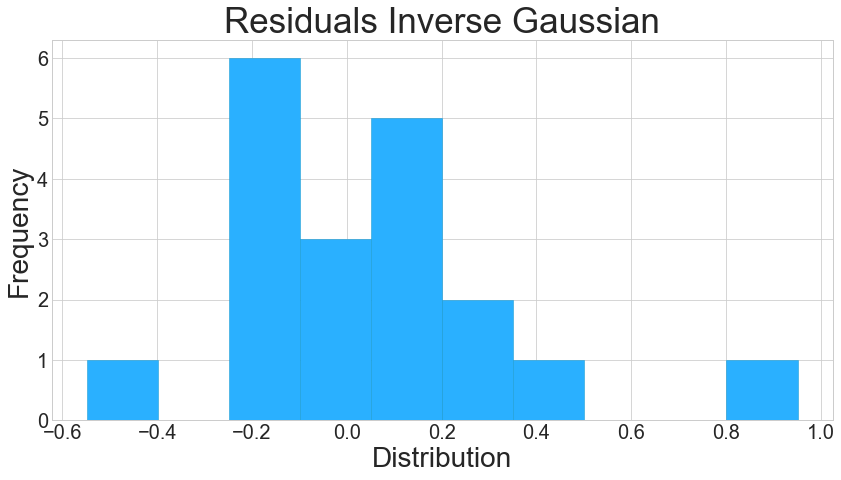

In [147]:
# Distribution residuals from model inverse Gaussian

plt.figure(figsize=(14,7)) # Make it 14x7 inch

plt.style.use('seaborn-whitegrid') # nice and clean grid

plt.hist(npxG_inv.resid_response, bins=10, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)

plt.title('Residuals Inverse Gaussian', fontsize=35) 

plt.xlabel('Distribution', fontsize=28) 

plt.ylabel('Frequency', fontsize=28)

plt.xticks(fontsize=20)

plt.yticks(fontsize=20)

plt.show()

In [148]:
# Shapiro-Wilk test, H0 : Normal Residuals

shapiro(npxG_inv.resid_response)

ShapiroResult(statistic=0.8967352509498596, pvalue=0.042480647563934326)

In [149]:
# Test data

test_data = Milan.loc[(Milan['Matchweek']>19).values].copy()

In [150]:
# Prediction of npxG_Expected from test dataset

test_data['npxG_pred'] = npxG_inv.predict(test_data)
test_data[['npxG_Expected','npxG_pred']]

,npxG_Expected,npxG_pred
19,1.4,0.793174
20,2.7,1.756054
21,1.8,1.633011
22,0.7,0.878712
23,1.4,1.089254
24,1.5,1.205066
25,1.3,0.730239
26,0.7,1.072629


In [151]:
# Deviance model npxG_inv

D_npxG_inv = mean_gamma_deviance(test_data['npxG_Expected'],test_data['npxG_pred'])
D_npxG_inv

0.1690312518663089

## PREDICTIONS

In [152]:
# Prediction of npxG_Expected for the game Naples VS Milan using mean value of the Rossoneri and opponent team and the model npxG

data = {'Opponent_percent_Pressures' : SerieA[SerieA['Team']=='Napoli']['percent_Pressures'].mean(), 'Def_Touches':Milan['Def_Touches'].mean(),\
        'Milan_Performance':[Milan.loc[26,'Milan_Performance']-0.5], 'Milan_Cup':1,'Att_Pressures':Milan['Att_Pressures'].mean()}
NapVSMil = pd.DataFrame(data = data)
npxG.predict(NapVSMil) # the real one is 1.1 from FBref

0    1.223065
dtype: float64

In [153]:
# Prediction of npxG_Expected for the game Naples VS Milan using real data of the Rossoneri and opponent team and the model npxG

data = {'Opponent_percent_Pressures' : 37.1, 'Def_Touches':202,\
        'Milan_Performance':[Milan.loc[26,'Milan_Performance']-0.5], 'Milan_Cup':1,'Att_Pressures':69}
NapVSMil = pd.DataFrame(data = data)
npxG.predict(NapVSMil) # the real one is 1.1 from FBref

0    1.149154
dtype: float64

In [154]:
# Check the Milan_Perfomance in order to fix the correct value for the next game

performance = Milan.loc[26,'Milan_Performance']-0.5
performance

1.0

In [155]:
# Update of the statistics for forecasting Milan VS Empoli, adding new row of stats from their last match

data = {'Opponent_percent_Pressures' : SerieA[(SerieA['Team']=='Empoli')]['percent_Pressures'].reset_index(drop=True), 'Def_Touches':Milan['Def_Touches'],\
        'Milan_Performance':Milan['Milan_Performance'], 'Milan_Cup':Milan['Milan_Cup'],'Att_Pressures':Milan['Att_Pressures']}
df = pd.DataFrame(data = data)
df.loc[27,:] = [32.5,202,2,0,69]

In [156]:
# Prediction of npxG_Expected for the game Milan VS Empoli using mean value of the Rossoneri and opponent team and the model npxG

data = {'Opponent_percent_Pressures' : df['Opponent_percent_Pressures'].mean(), 'Def_Touches':df['Def_Touches'].mean(),\
        'Milan_Performance':[df.loc[27,'Milan_Performance']], 'Milan_Cup':[df.loc[27,'Milan_Cup']],'Att_Pressures':df['Att_Pressures'].mean()}
MilVSEmp = pd.DataFrame(data = data)
npxG.predict(MilVSEmp) # the real one is 0.7 from FBref

0    1.470537
dtype: float64

In [157]:
# Prediction of npxG_Expected for the game Milan VS Milan using real data of the Rossoneri and opponent team and the model npxG

data = {'Opponent_percent_Pressures' : 31.7, 'Def_Touches':211,\
        'Milan_Performance':[df.loc[27,'Milan_Performance']], 'Milan_Cup':[df.loc[27,'Milan_Cup']],'Att_Pressures':50}
MilVSEmp = pd.DataFrame(data = data)
npxG.predict(MilVSEmp) # the real one is 0.7 from FBref

0    1.32834
dtype: float64

In [158]:
# Update of the statistics for forecasting Cagliari VS Milan, adding new row of stats from their last match

data = {'Opponent_percent_Pressures' : SerieA[(SerieA['Team']=='Cagliari')]['percent_Pressures'].reset_index(drop=True), 'Def_Touches':Milan['Def_Touches'],\
        'Milan_Performance':Milan['Milan_Performance'], 'Milan_Cup':Milan['Milan_Cup'],'Att_Pressures':Milan['Att_Pressures']}
df = pd.DataFrame(data = data)
df.loc[27,:] = [29.7,202,2,0,69]
df.loc[28,:] = [31.3,211,2,0,50]

In [159]:
# Prediction of npxG_Expected for the game Cagliari VS Milan using mean value of the Rossoneri and opponent team and the model npxG

data = {'Opponent_percent_Pressures' : df['Opponent_percent_Pressures'].mean(), 'Def_Touches':df['Def_Touches'].mean(),\
        'Milan_Performance':[df.loc[28,'Milan_Performance']], 'Milan_Cup':[df.loc[28,'Milan_Cup']],'Att_Pressures':df['Att_Pressures'].mean()}
CagVSMil = pd.DataFrame(data = data)
npxG.predict(CagVSMil) # the real one is 2.4 from FBref

0    1.456363
dtype: float64

In [160]:
# Prediction of npxG_Expected for the game Cagliari VS Milan using real data of the Rossoneri and opponent team and the model npxG

data = {'Opponent_percent_Pressures' : 35.1, 'Def_Touches':203,\
        'Milan_Performance':[2], 'Milan_Cup':0,'Att_Pressures':33}
CagVSMil = pd.DataFrame(data = data)
npxG.predict(CagVSMil) # the real one is 2.4 from FBref

0    0.762656
dtype: float64